<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

--2023-06-10 23:54:30--  http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.159.35
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.159.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244982259 (234M) [application/zip]
Saving to: ‘20170327_qsm2016_recon_challenge.zip’

20170327_qsm2016_re 100%[===================>] 233.63M  13.3MB/s    in 19s     

2023-06-10 23:54:49 (12.3 MB/s) - ‘20170327_qsm2016_recon_challenge.zip’ saved [244982259/244982259]

Archive:  20170327_qsm2016_recon_challenge.zip
   creating: 20170327_qsm2016_recon_challenge/
   creating: 20170327_qsm2016_recon_challenge/data/
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.nii.gz  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.nii.gz  
  infl

##### *Libraries*

In [2]:
!pip install -q tensorflow==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [3]:
# Importing libraries
import os
import pickle
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import transforms

import tensorflow as tf
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

##### *Utils functions*

In [4]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#--------------------------#
#       Random size 
#--------------------------#
def creating_random_size(min_size, max_size):
  random_size = np.random.randint(low = min_size, high = max_size)
  return random_size



#--------------------------#
# Susceptibility simulation
#--------------------------#
def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    spheres_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    # Creating random sizes
    random_sizex = creating_random_size(shape_size_min,shape_size_max)
    random_sizey = creating_random_size(shape_size_min,shape_size_max)
    random_sizez = creating_random_size(shape_size_min,shape_size_max)
    # Getting axis positions
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
      x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
      y_pos_max = simulation_dim 

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
      z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources

import numpy as np



#--------------------------#
#     Dipole kernel 3D
#--------------------------#
def create_dipole_kernel_3D(data_shape, voxel_size, b_vec):
    # Calculate the field of view
    fov = np.array(data_shape) * np.array(voxel_size)
    
    # Generate the x, y, and z coordinates of the image grid and
    # Create a meshgrid of the x, y, and z coordinates
    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                          np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                          np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    
    # Normalize the x, y, and z coordinates by the field of view
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    
    # Calculate the squared distance from the origin
    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    
    # Calculate the dipole kernel
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1/3 - d2)
    
    return kernel


#--------------------------------------#
#   Forward convolution with padding
#--------------------------------------#
def simulate_mri_tissue_phase(sample, padding=20):
    # Pad the sample to avoid wrap-around at the edges
    padded_sample = np.pad(sample, pad_width=padding, mode='constant')

    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(padded_sample.size)
    
    # Perform Fourier transform of the padded sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    # Crop the padded regions to match the original sample size
    tissue_phase_cropped = tissue_phase[padding:-padding, padding:-padding, padding:-padding]

    return tissue_phase_cropped


#--------------------------------------#
#     Forward convolution no padding
#--------------------------------------#
def simulate_mri_tissue_phase_no_padding(sample):
    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(sample.size)
    
    # Perform Fourier transform of the sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase


In [5]:
#--------------------------------------#
#     Creating batches for data
#--------------------------------------#
def create_batch(dimension, patch_idx, gt_full, fw_full):
    # Get the dimensions of the ground truth data
    x_max, y_max, z_max = gt_full.shape

    # Generate random indices for selecting the patch
    random_indices = np.random.choice(x_max - dimension, 3)
    randomX, randomY, randomZ = random_indices

    # Extract the patch using tuple indexing
    gt_patch = gt_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]
    fw_patch = fw_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]

    # Return the extracted patches
    return gt_patch, fw_patch

#--------------------------------------#
#     Custom IoU metric function
#--------------------------------------#
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

##### Images exploration by views

<ipython-input-6-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-6-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


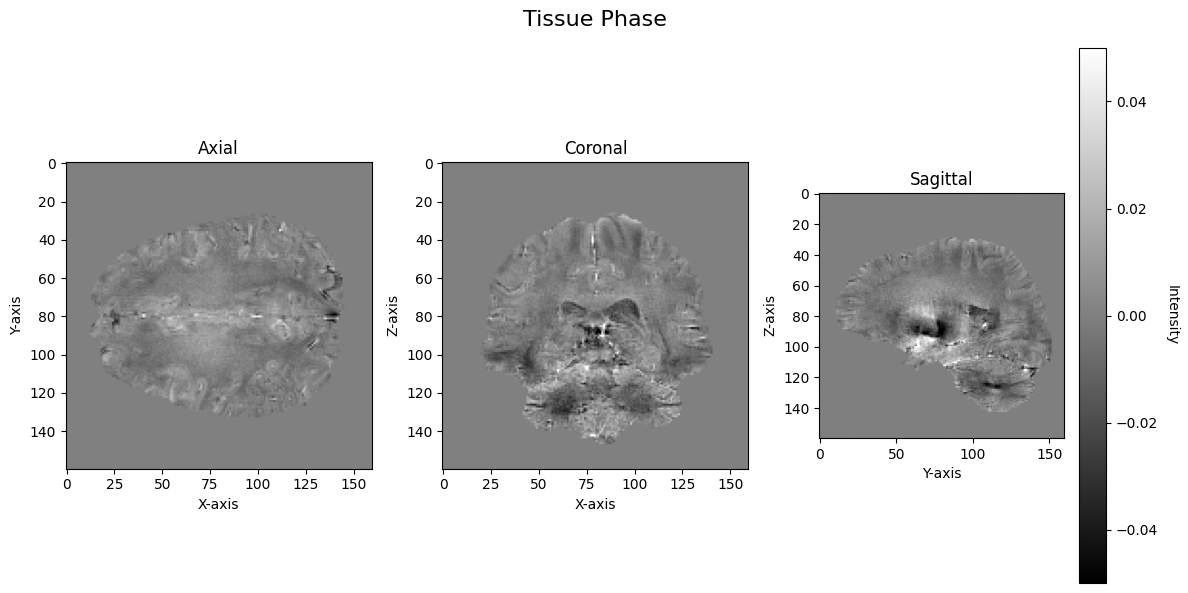

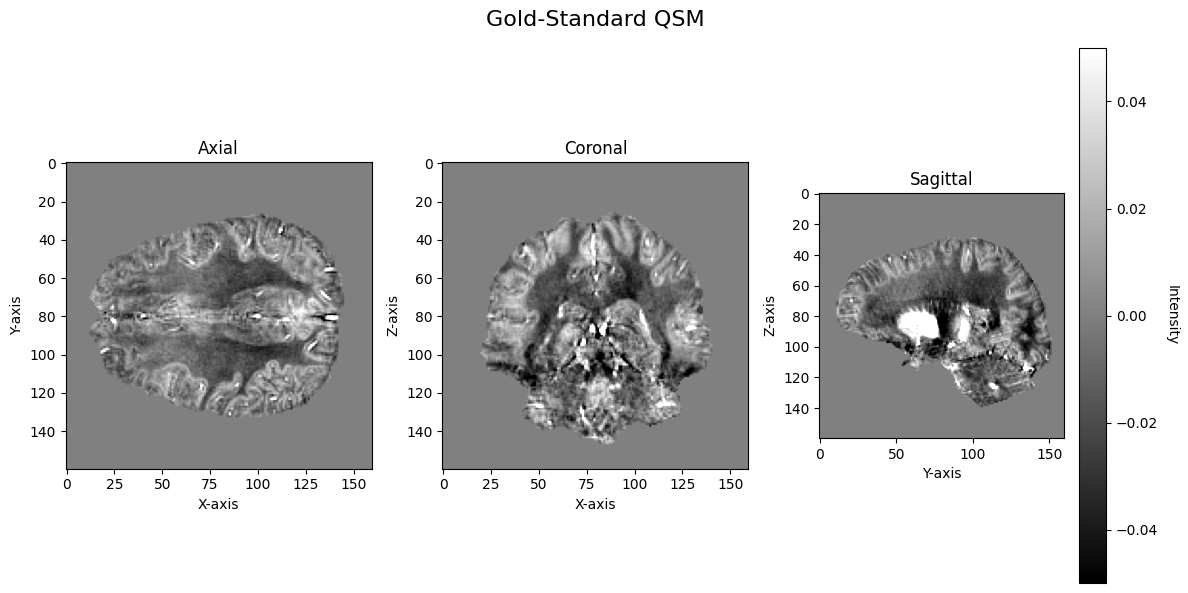

In [6]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 

##### *Simulation of susceptibility distribution*


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 160.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 157.0 ------- 


 ------- Shape 

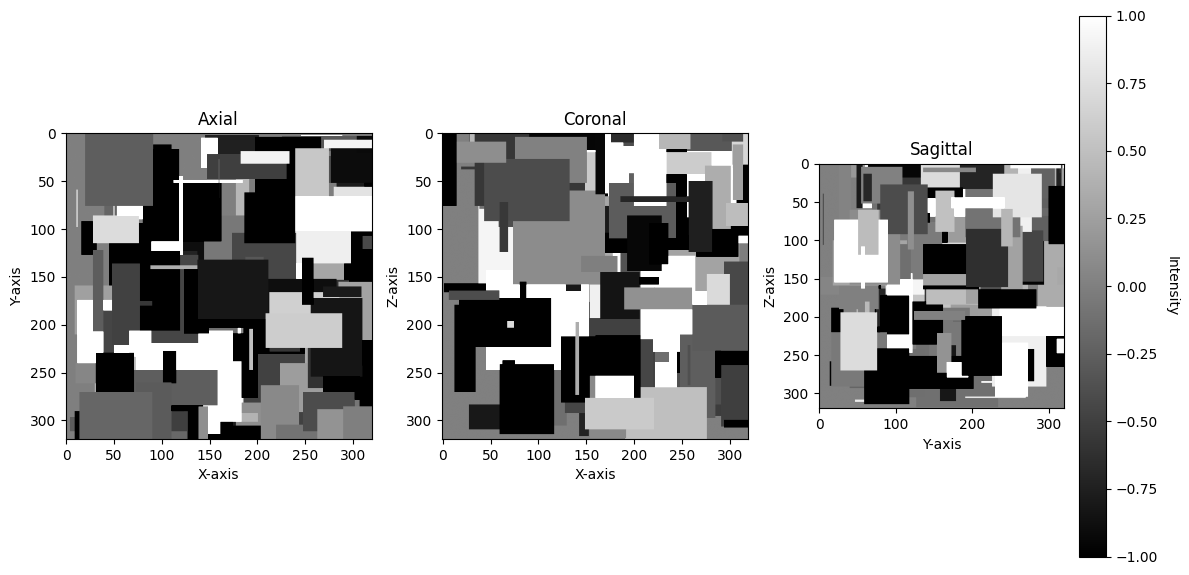

In [7]:
# sim_gt_full = simulated_ground_truth
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

##### *Convolve susceptibility distribution with dipole kernel to yield tissue phase* 


Dipole Kernel: The code generates a 3D dipole kernel using the generate_3d_dipole_kernel function. This kernel represents the response of a magnetic dipole in a magnetic resonance imaging (MRI) system. It is used to model the interaction between the sample and the imaging system.

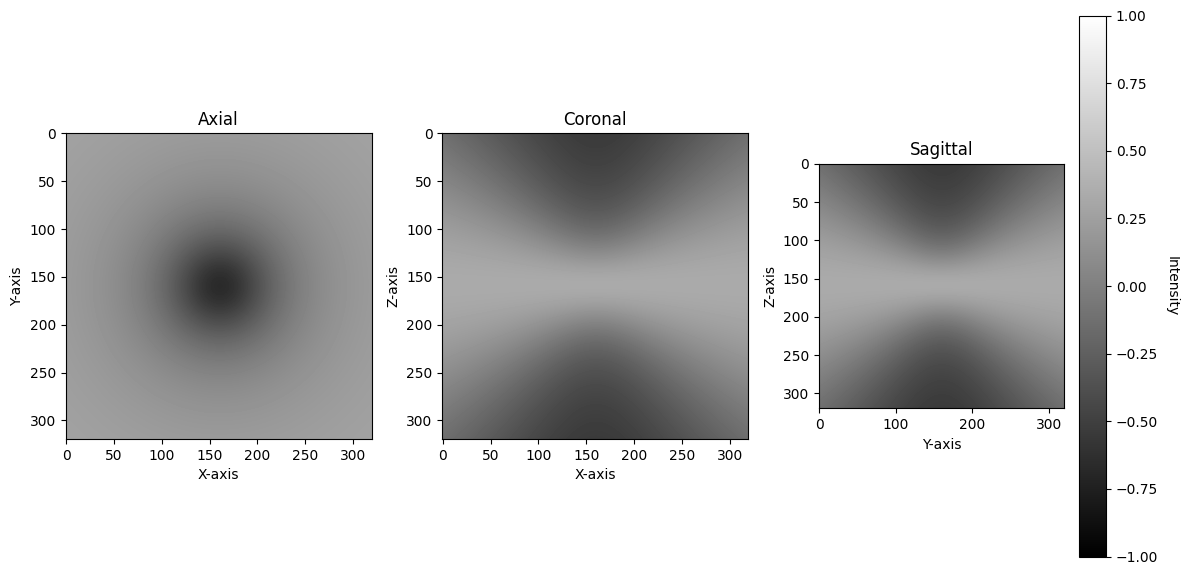

In [8]:
dipole_kernel3d = create_dipole_kernel_3D(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])
view_slices_3d(dipole_kernel3d, slice_nbr=100, vmin=-1, vmax=1)

- **Fourier Transform:** The code uses the np.fft.fftn function to compute the N-dimensional Fast Fourier Transform (FFT) of the input sample. The np.fft.fftshift function is used to shift the zero-frequency component to the center of the spectrum. This is a common step in Fourier analysis to obtain a more intuitive representation of the data.

- **Inverse Fourier Transform:** The code uses the np.fft.ifftn function to compute the N-dimensional Inverse FFT (IFFT) of the transformed sample. Again, the np.fft.fftshift function is used to shift the zero-frequency component back to the corners of the spectrum.
Scaling: To ensure proper normalization, the code divides the transformed samples by the square root of the sample size (scaling). This step is necessary to preserve the total energy of the data during the Fourier transformations.



- **Multiplication and Convolution:** The code multiplies the transformed sample by the dipole kernel in the Fourier domain. This multiplication corresponds to a convolution operation in the spatial domain. By performing the multiplication in the Fourier domain, the code exploits the convolution theorem, which states that multiplication in the Fourier domain is equivalent to convolution in the spatial domain.

- **Inverse Transform and Rescaling:** After multiplying the transformed sample by the dipole kernel, the code applies the inverse Fourier transform to obtain the spatial representation of the result. The resulting tissue phase is then rescaled by the scaling factor to restore the proper amplitude of the data.

- **Padding and Cropping:** In the forward_convolution_padding function, the input sample is padded with zeros before the Fourier transform to avoid wrap-around artifacts at the edges. After the inverse transform, the padded regions are cropped to match the size of the original sample.

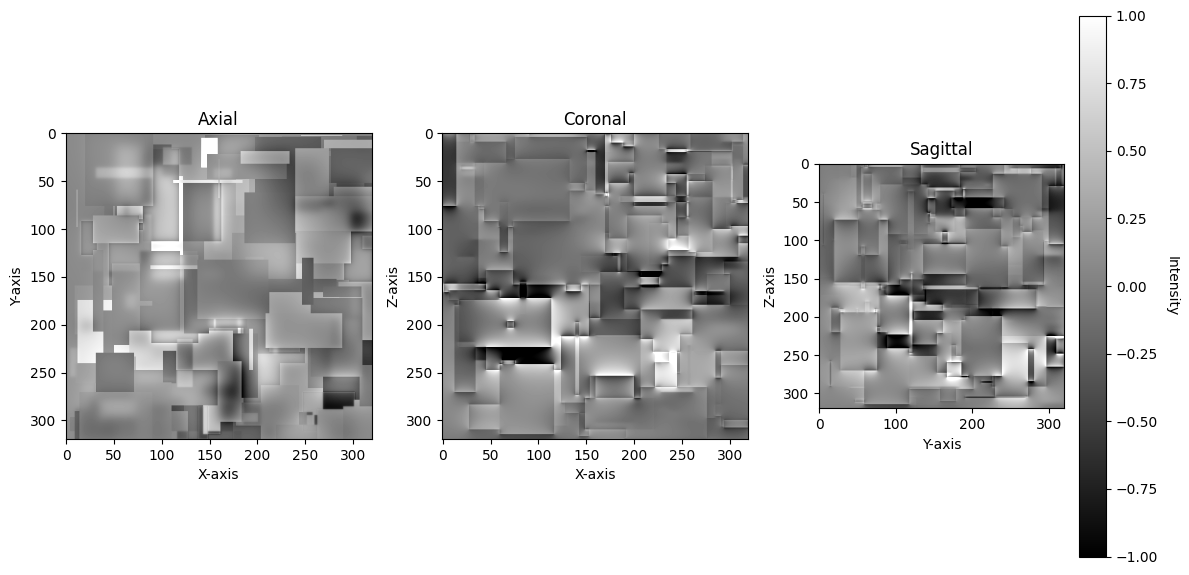

In [9]:
# Simulate tissue phase with padding
simulated_tissue_phase_full = simulate_mri_tissue_phase(sim_gt_full)
view_slices_3d(simulated_tissue_phase_full, slice_nbr=100, vmin=-1, vmax=1)

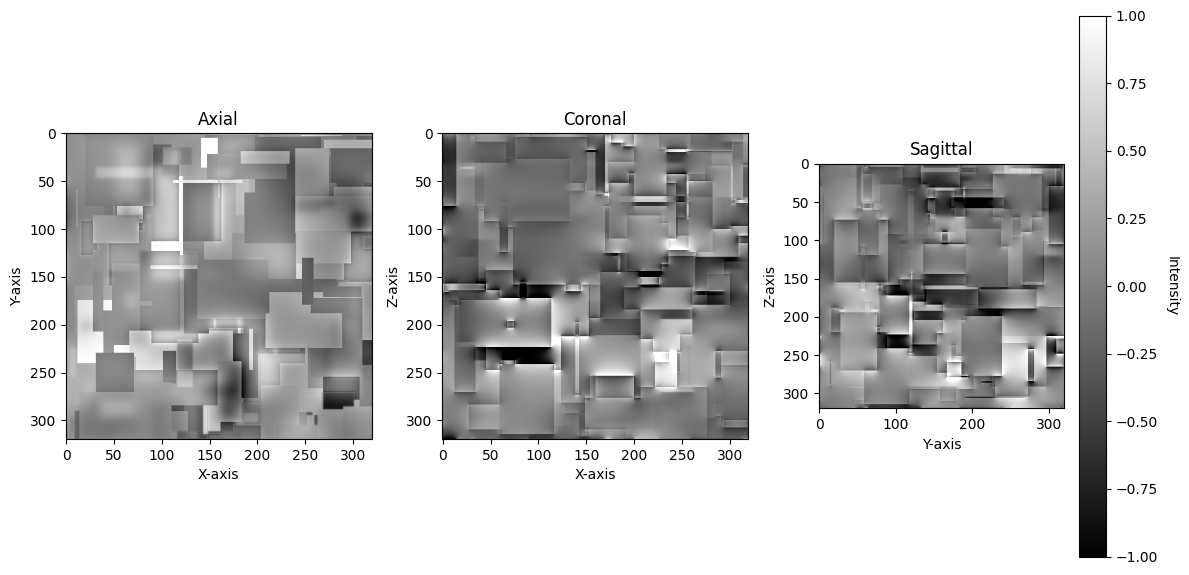

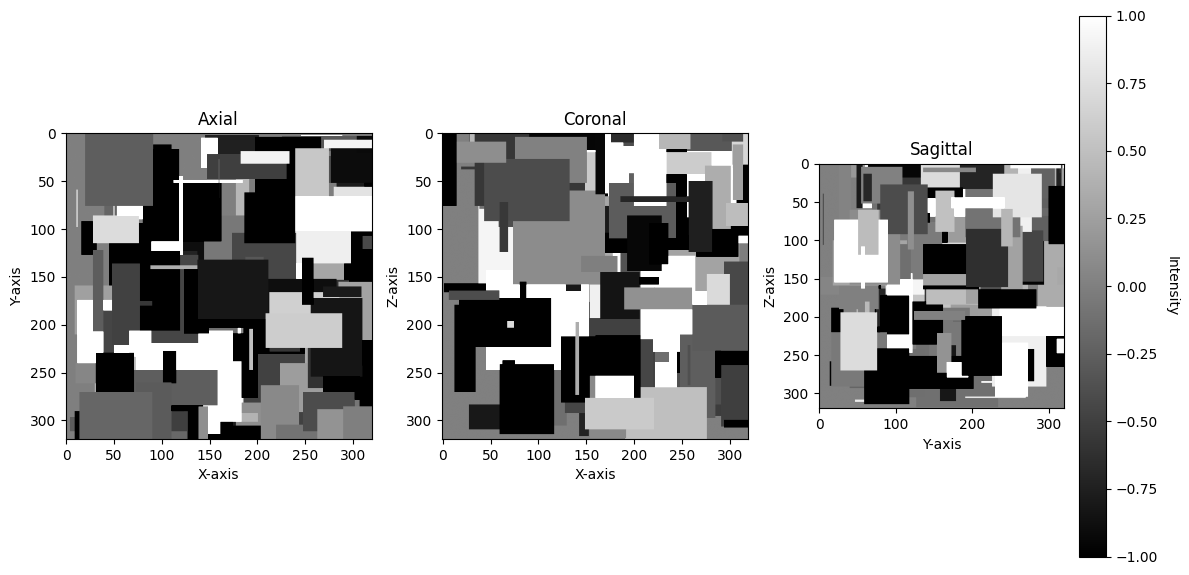

In [10]:
# Simulate tissue phase without padding
simulated_tissue_phase = simulate_mri_tissue_phase_no_padding(sim_gt_full)
view_slices_3d(simulated_tissue_phase, slice_nbr=100, vmin=-1, vmax=1)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#### Training a model to invert the dipole convolution 

###### Prepare patches for training

In [11]:
total_patches = 500
training_dim = 64

# Split patches to train from our simulations in ground truth and forward
simulation_gt_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))
simulation_fw_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))


for patch_idx in range(total_patches):
  simulation_gt_patches[patch_idx, :, :, :], simulation_fw_patches[patch_idx, :, :, :] = create_batch(training_dim, patch_idx,sim_gt_full,simulated_tissue_phase)


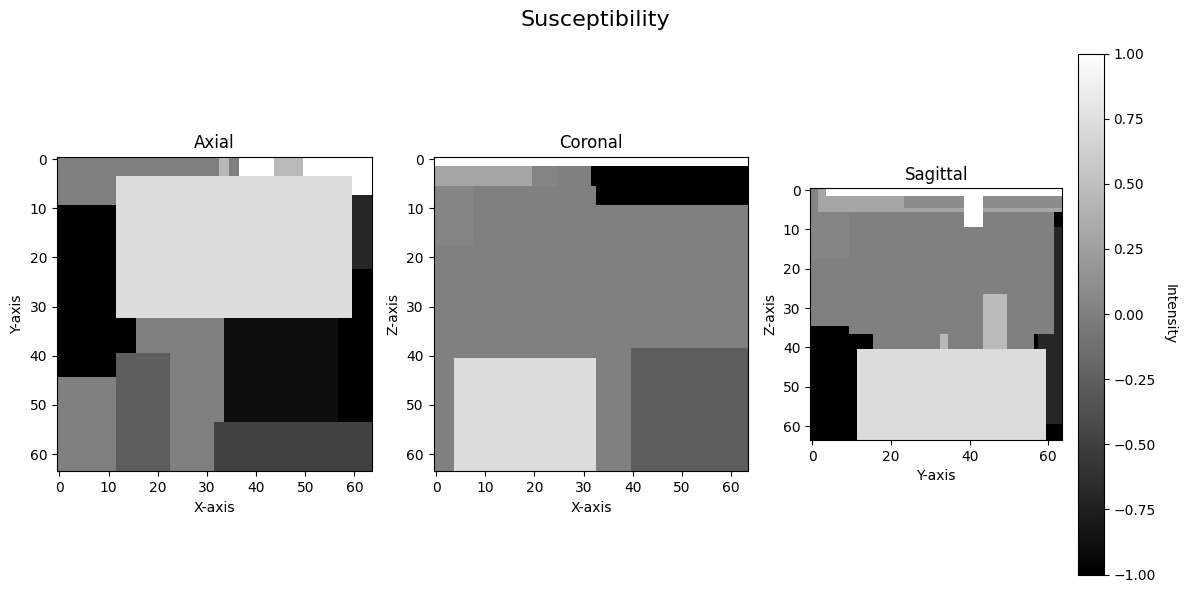

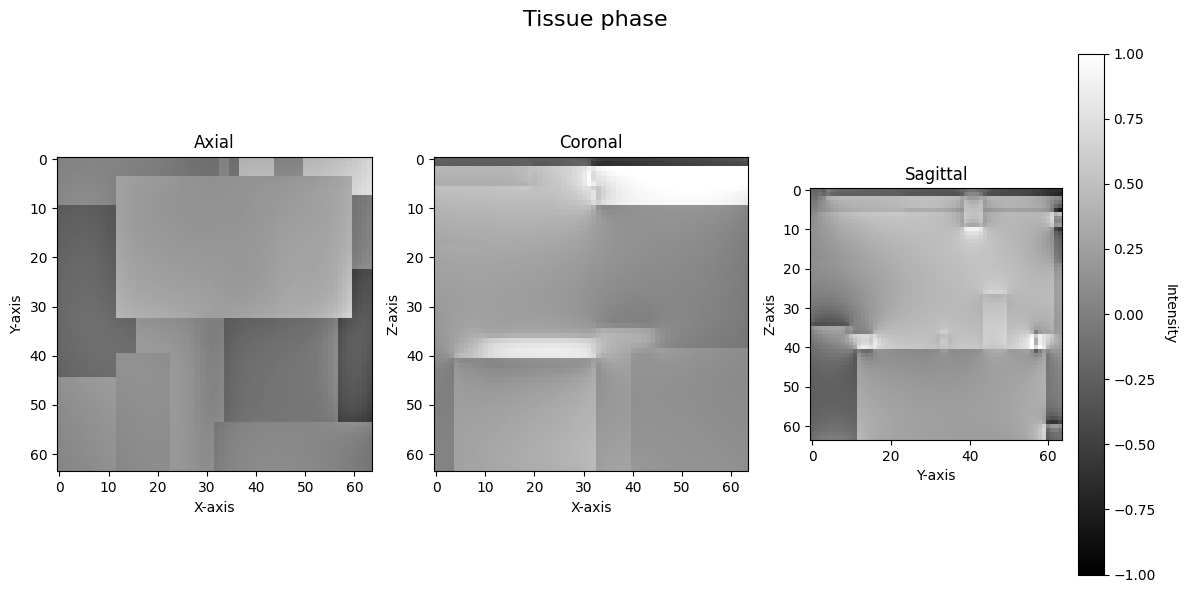

In [12]:
patch_idx = 40
view_slices_3d(simulation_gt_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Susceptibility')
view_slices_3d(simulation_fw_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Tissue phase')

##### Building architectures


In [13]:
# Print TensorFlow version
print(tf.__version__)

# Check GPU device availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('Running without GPU acceleration.')

2.12.0
Found GPU at: /device:GPU:0


###### Utils for architectures

In [14]:
# Utils function to construct the model

def downsample(filters, kernel_size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())

    return block


def upsample(filters, kernel_size, apply_dropout=False, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.6))
    block.add(tf.keras.layers.ReLU())

    return block



class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        print(f"  - Loss: {logs['loss']:.4f}")
        print(f"  - Mean Squared Error: {logs['mse']:.4f}")


In [15]:
# Testing downsample and upsample functions
inp = simulation_fw_patches[0,:,:,:]
print(f"Origianl shape in fw_pathces: {inp.shape}")
inp = tf.expand_dims(inp,0)
print(f"Expanding shape in fw_pathces first position: {inp.shape}")
inp = tf.expand_dims(inp,4)
print(f"Expanding shape in fw_pathces last position: {inp.shape}")

# Downsample
#(batch,x,y,z,channel)
down_sample = downsample(filters=8, kernel_size=4)
reduction = down_sample(inp)
print(f"Shape in fw_pathces after downsample: {reduction.shape}")

#Upsample
up_sample = upsample(filters=8, kernel_size=4)
expansion = up_sample(reduction)
print(f"Shape in fw_pathces after upsample: {expansion.shape}")

Origianl shape in fw_pathces: (64, 64, 64)
Expanding shape in fw_pathces first position: (1, 64, 64, 64)
Expanding shape in fw_pathces last position: (1, 64, 64, 64, 1)
Shape in fw_pathces after downsample: (1, 32, 32, 32, 8)
Shape in fw_pathces after upsample: (1, 64, 64, 64, 8)


###### ***Parameters***

In [16]:
EPOCHS = 200
PERIOD_TO_STORE = 25
OUTPUT_CHANNELS = 1

###### ***Model 1 - Architecture***

In [17]:
def model_1(filter_base=32, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [36]:
from tensorflow.keras.optimizers import Nadam

unet_model1 = model_1()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = Nadam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model1.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_27 (Sequential)     (None, None, None,   864         ['input_4[0][0]']                
                                None, 32)                                                         
                                                                                                  
 sequential_28 (Sequential)     (None, None, None,   55552       ['sequential_27[0][0]']          
                                None, 64)                                                   

###### ***Model 1 - Using the model to predict without training***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 548ms/step
Shape of testing data: (1, 64, 64, 64, 1)


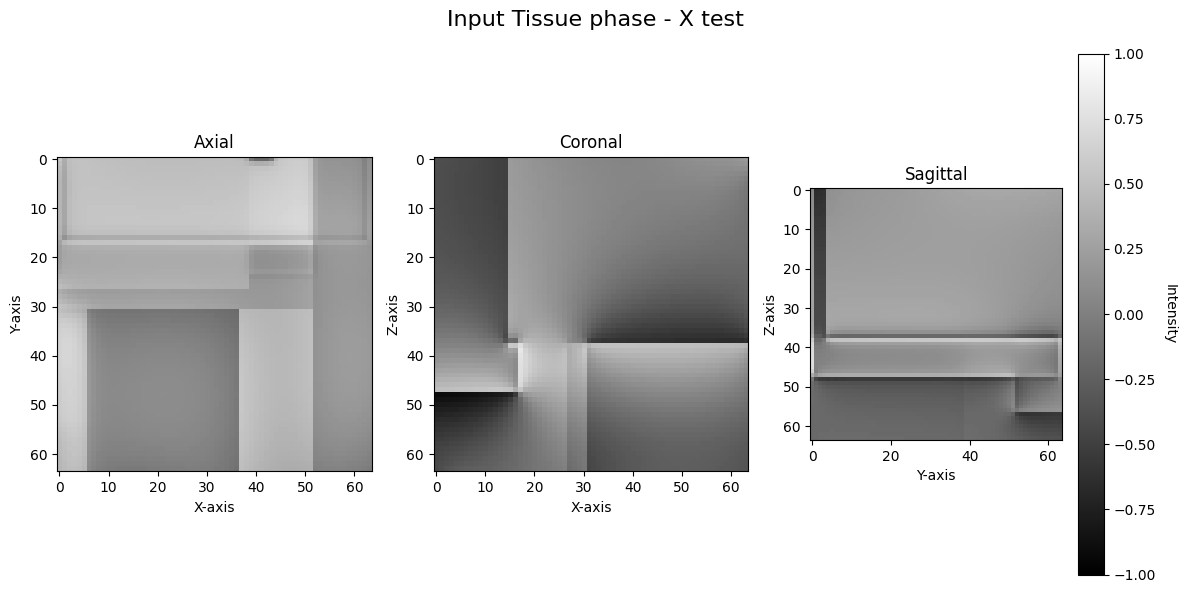

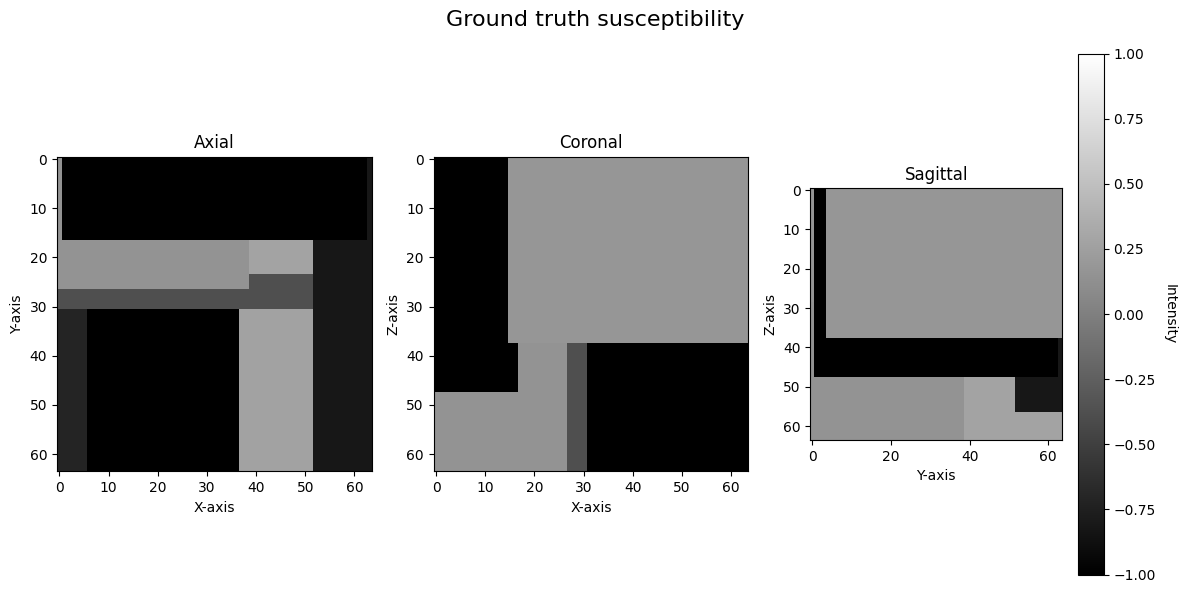

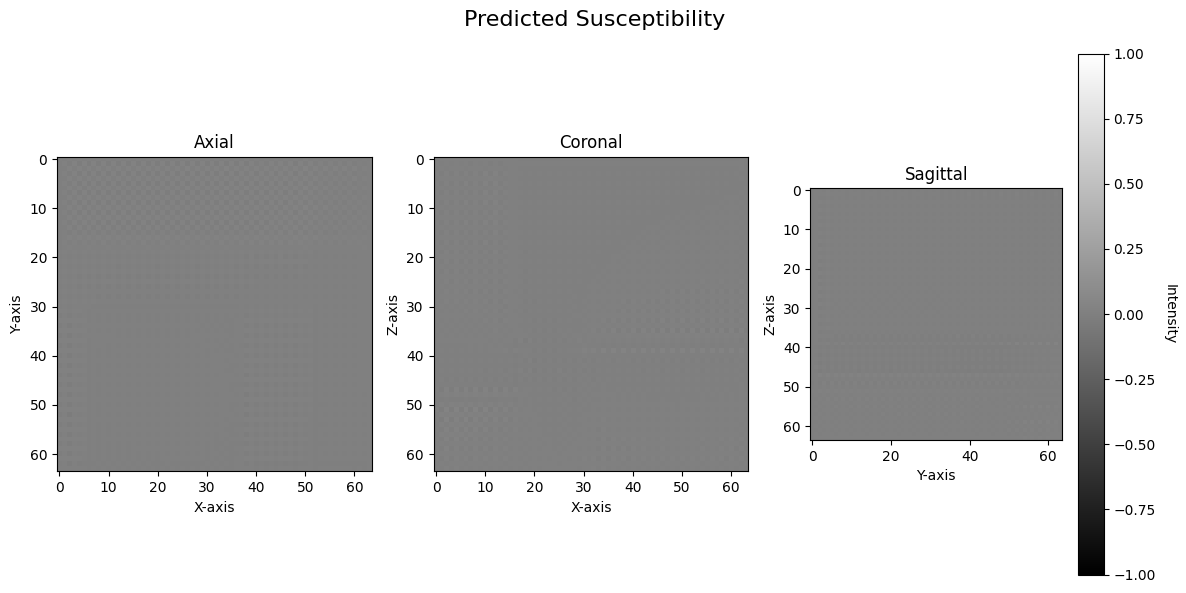

In [19]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model1.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


###### ***Model 1 - Trainning the model***

In [37]:
# Directories to store the checkpoints created
checkpoint_path_1 = "checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path_1)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_1,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Split data into training and validation sets
validation_split = 0.2
split_index = int(len(simulation_fw_patches) * (1 - validation_split))
train_images = tf.expand_dims(simulation_fw_patches[:split_index], 4)
train_labels = tf.expand_dims(simulation_gt_patches[:split_index], 4)
val_images = tf.expand_dims(simulation_fw_patches[split_index:], 4)
val_labels = tf.expand_dims(simulation_gt_patches[split_index:], 4)

# Train the model with validation data
loss_history_1 = []
val_loss_history_1 = []  # Store validation loss
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_1 = unet_model1.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_1.append(history_1.history["loss"][0])
        val_loss_history_1.append(history_1.history["val_loss"][0])  # Store validation loss
        
        # Clear memory after each epoch
        del history_1
        tf.keras.backend.clear_session()
        
        pbar.update(1)

# Save loss history
with open('loss_history_1.pickle', 'wb') as f:
    pickle.dump([loss_history_1, val_loss_history_1, len(loss_history_1)], f)

Training:   0%|          | 0/200 [00:00<?, ?it/s, Epoch=1]

13/14 [==========================>...] - ETA: 0s - loss: 0.8431
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 10s 132ms/step - loss: 0.8441 - val_loss: 0.9080


Training:   0%|          | 1/200 [00:10<33:16, 10.03s/it, Epoch=2]

13/14 [==========================>...] - ETA: 0s - loss: 0.6301
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 109ms/step - loss: 0.6251 - val_loss: 0.8966


Training:   1%|          | 2/200 [00:12<18:18,  5.55s/it, Epoch=3]

13/14 [==========================>...] - ETA: 0s - loss: 0.4597
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.4587 - val_loss: 0.9436


Training:   2%|▏         | 3/200 [00:14<13:19,  4.06s/it, Epoch=4]

13/14 [==========================>...] - ETA: 0s - loss: 0.3960
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.3952 - val_loss: 0.8470


Training:   2%|▏         | 4/200 [00:16<10:56,  3.35s/it, Epoch=5]

13/14 [==========================>...] - ETA: 0s - loss: 0.3274
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.3268 - val_loss: 0.7231


Training:   2%|▎         | 5/200 [00:19<09:36,  2.96s/it, Epoch=6]

13/14 [==========================>...] - ETA: 0s - loss: 0.2988
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2982 - val_loss: 0.6287


Training:   3%|▎         | 6/200 [00:21<08:46,  2.71s/it, Epoch=7]

13/14 [==========================>...] - ETA: 0s - loss: 0.2686
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.2677 - val_loss: 0.5754


Training:   4%|▎         | 7/200 [00:23<08:12,  2.55s/it, Epoch=8]

13/14 [==========================>...] - ETA: 0s - loss: 0.2444
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2440 - val_loss: 0.5407


Training:   4%|▍         | 8/200 [00:25<07:48,  2.44s/it, Epoch=9]

13/14 [==========================>...] - ETA: 0s - loss: 0.2307
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2316 - val_loss: 0.5680


Training:   4%|▍         | 9/200 [00:28<07:34,  2.38s/it, Epoch=10]

13/14 [==========================>...] - ETA: 0s - loss: 0.2317
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2304 - val_loss: 0.5347


Training:   5%|▌         | 10/200 [00:30<07:21,  2.32s/it, Epoch=11]

13/14 [==========================>...] - ETA: 0s - loss: 0.2170
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 118ms/step - loss: 0.2170 - val_loss: 0.5647


Training:   6%|▌         | 11/200 [00:32<07:22,  2.34s/it, Epoch=12]

13/14 [==========================>...] - ETA: 0s - loss: 0.2094
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2085 - val_loss: 0.5116


Training:   6%|▌         | 12/200 [00:34<07:13,  2.31s/it, Epoch=13]

13/14 [==========================>...] - ETA: 0s - loss: 0.2021
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.2044 - val_loss: 0.5523


Training:   6%|▋         | 13/200 [00:37<07:07,  2.29s/it, Epoch=14]

13/14 [==========================>...] - ETA: 0s - loss: 0.2017
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2011 - val_loss: 0.5080


Training:   7%|▋         | 14/200 [00:39<07:03,  2.28s/it, Epoch=15]

13/14 [==========================>...] - ETA: 0s - loss: 0.1948
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1943 - val_loss: 0.4887


Training:   8%|▊         | 15/200 [00:41<06:58,  2.26s/it, Epoch=16]

13/14 [==========================>...] - ETA: 0s - loss: 0.1907
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 115ms/step - loss: 0.1898 - val_loss: 0.4578


Training:   8%|▊         | 16/200 [00:44<07:01,  2.29s/it, Epoch=17]

13/14 [==========================>...] - ETA: 0s - loss: 0.1883
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1881 - val_loss: 0.4918


Training:   8%|▊         | 17/200 [00:46<06:54,  2.27s/it, Epoch=18]

13/14 [==========================>...] - ETA: 0s - loss: 0.1869
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1868 - val_loss: 0.4312


Training:   9%|▉         | 18/200 [00:48<06:50,  2.25s/it, Epoch=19]

13/14 [==========================>...] - ETA: 0s - loss: 0.1825
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1817 - val_loss: 0.3960


Training:  10%|▉         | 19/200 [00:50<06:45,  2.24s/it, Epoch=20]

13/14 [==========================>...] - ETA: 0s - loss: 0.1795
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1827 - val_loss: 0.3889


Training:  10%|█         | 20/200 [00:52<06:40,  2.22s/it, Epoch=21]

13/14 [==========================>...] - ETA: 0s - loss: 0.1754
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1791 - val_loss: 0.3526


Training:  10%|█         | 21/200 [00:55<06:38,  2.23s/it, Epoch=22]

13/14 [==========================>...] - ETA: 0s - loss: 0.1814
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1811 - val_loss: 0.3832


Training:  11%|█         | 22/200 [00:57<06:34,  2.22s/it, Epoch=23]

13/14 [==========================>...] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1759 - val_loss: 0.3260


Training:  12%|█▏        | 23/200 [00:59<06:31,  2.21s/it, Epoch=24]

13/14 [==========================>...] - ETA: 0s - loss: 0.1778
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1776 - val_loss: 0.3041


Training:  12%|█▏        | 24/200 [01:01<06:30,  2.22s/it, Epoch=25]

13/14 [==========================>...] - ETA: 0s - loss: 0.1723
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1755 - val_loss: 0.2851


Training:  12%|█▎        | 25/200 [01:03<06:28,  2.22s/it, Epoch=26]

13/14 [==========================>...] - ETA: 0s - loss: 0.1702
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1700 - val_loss: 0.2880


Training:  13%|█▎        | 26/200 [01:06<06:24,  2.21s/it, Epoch=27]

13/14 [==========================>...] - ETA: 0s - loss: 0.1687
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1679 - val_loss: 0.2729


Training:  14%|█▎        | 27/200 [01:08<06:21,  2.21s/it, Epoch=28]

13/14 [==========================>...] - ETA: 0s - loss: 0.1660
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1678 - val_loss: 0.2651


Training:  14%|█▍        | 28/200 [01:10<06:18,  2.20s/it, Epoch=29]

13/14 [==========================>...] - ETA: 0s - loss: 0.1713
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1699 - val_loss: 0.2629


Training:  14%|█▍        | 29/200 [01:12<06:16,  2.20s/it, Epoch=30]

13/14 [==========================>...] - ETA: 0s - loss: 0.1638
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1665 - val_loss: 0.2674


Training:  15%|█▌        | 30/200 [01:14<06:14,  2.20s/it, Epoch=31]

13/14 [==========================>...] - ETA: 0s - loss: 0.1729
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1725 - val_loss: 0.2586


Training:  16%|█▌        | 31/200 [01:17<06:11,  2.20s/it, Epoch=32]

13/14 [==========================>...] - ETA: 0s - loss: 0.1715
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1706 - val_loss: 0.2669


Training:  16%|█▌        | 32/200 [01:19<06:10,  2.20s/it, Epoch=33]

13/14 [==========================>...] - ETA: 0s - loss: 0.1729
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1727 - val_loss: 0.2688


Training:  16%|█▋        | 33/200 [01:21<06:08,  2.21s/it, Epoch=34]

13/14 [==========================>...] - ETA: 0s - loss: 0.1677
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1690 - val_loss: 0.2577


Training:  17%|█▋        | 34/200 [01:23<06:06,  2.21s/it, Epoch=35]

13/14 [==========================>...] - ETA: 0s - loss: 0.1659
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1657 - val_loss: 0.2457


Training:  18%|█▊        | 35/200 [01:25<06:05,  2.22s/it, Epoch=36]

13/14 [==========================>...] - ETA: 0s - loss: 0.1647
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1640 - val_loss: 0.2428


Training:  18%|█▊        | 36/200 [01:28<06:04,  2.22s/it, Epoch=37]

13/14 [==========================>...] - ETA: 0s - loss: 0.1637
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1638 - val_loss: 0.2391


Training:  18%|█▊        | 37/200 [01:30<06:00,  2.21s/it, Epoch=38]

13/14 [==========================>...] - ETA: 0s - loss: 0.1624
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1633 - val_loss: 0.2443


Training:  19%|█▉        | 38/200 [01:32<05:58,  2.21s/it, Epoch=39]

13/14 [==========================>...] - ETA: 0s - loss: 0.1611
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1615 - val_loss: 0.2393


Training:  20%|█▉        | 39/200 [01:34<05:55,  2.21s/it, Epoch=40]

13/14 [==========================>...] - ETA: 0s - loss: 0.1639
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1620 - val_loss: 0.2473


Training:  20%|██        | 40/200 [01:37<05:52,  2.20s/it, Epoch=41]

13/14 [==========================>...] - ETA: 0s - loss: 0.1561
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1596 - val_loss: 0.2415


Training:  20%|██        | 41/200 [01:39<05:50,  2.21s/it, Epoch=42]

13/14 [==========================>...] - ETA: 0s - loss: 0.1575
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1563 - val_loss: 0.2437


Training:  21%|██        | 42/200 [01:41<05:48,  2.21s/it, Epoch=43]

13/14 [==========================>...] - ETA: 0s - loss: 0.1571
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1579 - val_loss: 0.2505


Training:  22%|██▏       | 43/200 [01:43<05:46,  2.21s/it, Epoch=44]

13/14 [==========================>...] - ETA: 0s - loss: 0.1585
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1598 - val_loss: 0.2361


Training:  22%|██▏       | 44/200 [01:45<05:43,  2.20s/it, Epoch=45]

13/14 [==========================>...] - ETA: 0s - loss: 0.1607
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1594 - val_loss: 0.2363


Training:  22%|██▎       | 45/200 [01:48<05:41,  2.20s/it, Epoch=46]

13/14 [==========================>...] - ETA: 0s - loss: 0.1580
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1566 - val_loss: 0.2336


Training:  23%|██▎       | 46/200 [01:50<05:38,  2.20s/it, Epoch=47]

13/14 [==========================>...] - ETA: 0s - loss: 0.1604
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1596 - val_loss: 0.2371


Training:  24%|██▎       | 47/200 [01:52<05:37,  2.20s/it, Epoch=48]

13/14 [==========================>...] - ETA: 0s - loss: 0.1566
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1580 - val_loss: 0.2442


Training:  24%|██▍       | 48/200 [01:54<05:36,  2.21s/it, Epoch=49]

13/14 [==========================>...] - ETA: 0s - loss: 0.1575
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1568 - val_loss: 0.2432


Training:  24%|██▍       | 49/200 [01:56<05:34,  2.21s/it, Epoch=50]

13/14 [==========================>...] - ETA: 0s - loss: 0.1541
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1564 - val_loss: 0.2506


Training:  25%|██▌       | 50/200 [01:59<05:32,  2.21s/it, Epoch=51]

13/14 [==========================>...] - ETA: 0s - loss: 0.1575
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1576 - val_loss: 0.2509


Training:  26%|██▌       | 51/200 [02:01<05:29,  2.21s/it, Epoch=52]

13/14 [==========================>...] - ETA: 0s - loss: 0.1564
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1565 - val_loss: 0.2358


Training:  26%|██▌       | 52/200 [02:03<05:26,  2.21s/it, Epoch=53]

13/14 [==========================>...] - ETA: 0s - loss: 0.1536
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1534 - val_loss: 0.2380


Training:  26%|██▋       | 53/200 [02:05<05:25,  2.21s/it, Epoch=54]

13/14 [==========================>...] - ETA: 0s - loss: 0.1556
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1551 - val_loss: 0.2375


Training:  27%|██▋       | 54/200 [02:07<05:23,  2.21s/it, Epoch=55]

13/14 [==========================>...] - ETA: 0s - loss: 0.1545
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1547 - val_loss: 0.2431


Training:  28%|██▊       | 55/200 [02:10<05:20,  2.21s/it, Epoch=56]

13/14 [==========================>...] - ETA: 0s - loss: 0.1545
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1554 - val_loss: 0.2330


Training:  28%|██▊       | 56/200 [02:12<05:18,  2.21s/it, Epoch=57]

13/14 [==========================>...] - ETA: 0s - loss: 0.1524
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1528 - val_loss: 0.2358


Training:  28%|██▊       | 57/200 [02:14<05:17,  2.22s/it, Epoch=58]

13/14 [==========================>...] - ETA: 0s - loss: 0.1517
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1525 - val_loss: 0.2337


Training:  29%|██▉       | 58/200 [02:16<05:16,  2.23s/it, Epoch=59]

13/14 [==========================>...] - ETA: 0s - loss: 0.1534
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1527 - val_loss: 0.2300


Training:  30%|██▉       | 59/200 [02:19<05:12,  2.22s/it, Epoch=60]

13/14 [==========================>...] - ETA: 0s - loss: 0.1567
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1561 - val_loss: 0.2482


Training:  30%|███       | 60/200 [02:21<05:10,  2.22s/it, Epoch=61]

13/14 [==========================>...] - ETA: 0s - loss: 0.1578
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1562 - val_loss: 0.2312


Training:  30%|███       | 61/200 [02:23<05:11,  2.24s/it, Epoch=62]

13/14 [==========================>...] - ETA: 0s - loss: 0.1542
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1538 - val_loss: 0.2330


Training:  31%|███       | 62/200 [02:25<05:07,  2.23s/it, Epoch=63]

13/14 [==========================>...] - ETA: 0s - loss: 0.1559
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1557 - val_loss: 0.2514


Training:  32%|███▏      | 63/200 [02:28<05:06,  2.24s/it, Epoch=64]

13/14 [==========================>...] - ETA: 0s - loss: 0.1535
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1541 - val_loss: 0.2289


Training:  32%|███▏      | 64/200 [02:30<05:05,  2.25s/it, Epoch=65]

13/14 [==========================>...] - ETA: 0s - loss: 0.1549
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1537 - val_loss: 0.2301


Training:  32%|███▎      | 65/200 [02:32<05:02,  2.24s/it, Epoch=66]

13/14 [==========================>...] - ETA: 0s - loss: 0.1533
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1528 - val_loss: 0.2299


Training:  33%|███▎      | 66/200 [02:34<05:01,  2.25s/it, Epoch=67]

13/14 [==========================>...] - ETA: 0s - loss: 0.1546
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1548 - val_loss: 0.2365


Training:  34%|███▎      | 67/200 [02:37<04:58,  2.25s/it, Epoch=68]

13/14 [==========================>...] - ETA: 0s - loss: 0.1516
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1529 - val_loss: 0.2306


Training:  34%|███▍      | 68/200 [02:39<04:54,  2.23s/it, Epoch=69]

13/14 [==========================>...] - ETA: 0s - loss: 0.1525
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 143ms/step - loss: 0.1519 - val_loss: 0.2365


Training:  34%|███▍      | 69/200 [02:41<05:11,  2.38s/it, Epoch=70]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 112ms/step - loss: 0.1493 - val_loss: 0.2292


Training:  35%|███▌      | 70/200 [02:44<05:28,  2.53s/it, Epoch=71]

13/14 [==========================>...] - ETA: 0s - loss: 0.1503
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 111ms/step - loss: 0.1512 - val_loss: 0.2302


Training:  36%|███▌      | 71/200 [02:47<05:32,  2.57s/it, Epoch=72]

13/14 [==========================>...] - ETA: 0s - loss: 0.1492
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 117ms/step - loss: 0.1481 - val_loss: 0.2262


Training:  36%|███▌      | 72/200 [02:50<05:31,  2.59s/it, Epoch=73]

13/14 [==========================>...] - ETA: 0s - loss: 0.1502
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1501 - val_loss: 0.2288


Training:  36%|███▋      | 73/200 [02:52<05:19,  2.52s/it, Epoch=74]

13/14 [==========================>...] - ETA: 0s - loss: 0.1485
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1493 - val_loss: 0.2326


Training:  37%|███▋      | 74/200 [02:54<05:08,  2.44s/it, Epoch=75]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1480 - val_loss: 0.2306


Training:  38%|███▊      | 75/200 [02:57<04:59,  2.40s/it, Epoch=76]

13/14 [==========================>...] - ETA: 0s - loss: 0.1480
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1482 - val_loss: 0.2291


Training:  38%|███▊      | 76/200 [02:59<04:51,  2.35s/it, Epoch=77]

13/14 [==========================>...] - ETA: 0s - loss: 0.1479
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1473 - val_loss: 0.2335


Training:  38%|███▊      | 77/200 [03:01<04:46,  2.33s/it, Epoch=78]

13/14 [==========================>...] - ETA: 0s - loss: 0.1472
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1485 - val_loss: 0.2332


Training:  39%|███▉      | 78/200 [03:03<04:39,  2.29s/it, Epoch=79]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1474 - val_loss: 0.2366


Training:  40%|███▉      | 79/200 [03:05<04:33,  2.26s/it, Epoch=80]

13/14 [==========================>...] - ETA: 0s - loss: 0.1502
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1484 - val_loss: 0.2300


Training:  40%|████      | 80/200 [03:08<04:29,  2.25s/it, Epoch=81]

13/14 [==========================>...] - ETA: 0s - loss: 0.1501
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1490 - val_loss: 0.2292


Training:  40%|████      | 81/200 [03:10<04:27,  2.25s/it, Epoch=82]

13/14 [==========================>...] - ETA: 0s - loss: 0.1472
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1495 - val_loss: 0.2307


Training:  41%|████      | 82/200 [03:12<04:24,  2.24s/it, Epoch=83]

13/14 [==========================>...] - ETA: 0s - loss: 0.1481
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1485 - val_loss: 0.2287


Training:  42%|████▏     | 83/200 [03:14<04:22,  2.25s/it, Epoch=84]

13/14 [==========================>...] - ETA: 0s - loss: 0.1489
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1510 - val_loss: 0.2274


Training:  42%|████▏     | 84/200 [03:17<04:17,  2.22s/it, Epoch=85]

13/14 [==========================>...] - ETA: 0s - loss: 0.1466
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1484 - val_loss: 0.2244


Training:  42%|████▎     | 85/200 [03:19<04:15,  2.22s/it, Epoch=86]

13/14 [==========================>...] - ETA: 0s - loss: 0.1481
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1481 - val_loss: 0.2303


Training:  43%|████▎     | 86/200 [03:21<04:12,  2.21s/it, Epoch=87]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1508 - val_loss: 0.2351


Training:  44%|████▎     | 87/200 [03:23<04:09,  2.21s/it, Epoch=88]

13/14 [==========================>...] - ETA: 0s - loss: 0.1496
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1499 - val_loss: 0.2326


Training:  44%|████▍     | 88/200 [03:25<04:07,  2.21s/it, Epoch=89]

13/14 [==========================>...] - ETA: 0s - loss: 0.1503
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1511 - val_loss: 0.2284


Training:  44%|████▍     | 89/200 [03:28<04:06,  2.22s/it, Epoch=90]

13/14 [==========================>...] - ETA: 0s - loss: 0.1495
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 110ms/step - loss: 0.1497 - val_loss: 0.2285


Training:  45%|████▌     | 90/200 [03:30<04:07,  2.25s/it, Epoch=91]

13/14 [==========================>...] - ETA: 0s - loss: 0.1490
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1485 - val_loss: 0.2243


Training:  46%|████▌     | 91/200 [03:32<04:05,  2.25s/it, Epoch=92]

13/14 [==========================>...] - ETA: 0s - loss: 0.1475
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1476 - val_loss: 0.2333


Training:  46%|████▌     | 92/200 [03:34<04:02,  2.25s/it, Epoch=93]

13/14 [==========================>...] - ETA: 0s - loss: 0.1498
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1489 - val_loss: 0.2248


Training:  46%|████▋     | 93/200 [03:37<03:59,  2.24s/it, Epoch=94]

13/14 [==========================>...] - ETA: 0s - loss: 0.1459
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 117ms/step - loss: 0.1471 - val_loss: 0.2237


Training:  47%|████▋     | 94/200 [03:39<04:01,  2.28s/it, Epoch=95]

13/14 [==========================>...] - ETA: 0s - loss: 0.1464
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1477 - val_loss: 0.2327


Training:  48%|████▊     | 95/200 [03:41<03:57,  2.27s/it, Epoch=96]

13/14 [==========================>...] - ETA: 0s - loss: 0.1504
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1508 - val_loss: 0.2332


Training:  48%|████▊     | 96/200 [03:44<03:56,  2.27s/it, Epoch=97]

13/14 [==========================>...] - ETA: 0s - loss: 0.1470
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1478 - val_loss: 0.2497


Training:  48%|████▊     | 97/200 [03:46<03:51,  2.25s/it, Epoch=98]

13/14 [==========================>...] - ETA: 0s - loss: 0.1528
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1522 - val_loss: 0.2526


Training:  49%|████▉     | 98/200 [03:48<03:47,  2.23s/it, Epoch=99]

13/14 [==========================>...] - ETA: 0s - loss: 0.1513
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1512 - val_loss: 0.2342


Training:  50%|████▉     | 99/200 [03:50<03:44,  2.22s/it, Epoch=100]

13/14 [==========================>...] - ETA: 0s - loss: 0.1477
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1487 - val_loss: 0.2310


Training:  50%|█████     | 100/200 [03:52<03:41,  2.22s/it, Epoch=101]

13/14 [==========================>...] - ETA: 0s - loss: 0.1462
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1469 - val_loss: 0.2319


Training:  50%|█████     | 101/200 [03:55<03:38,  2.21s/it, Epoch=102]

13/14 [==========================>...] - ETA: 0s - loss: 0.1479
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1474 - val_loss: 0.2311


Training:  51%|█████     | 102/200 [03:57<03:35,  2.20s/it, Epoch=103]

13/14 [==========================>...] - ETA: 0s - loss: 0.1504
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1490 - val_loss: 0.2254


Training:  52%|█████▏    | 103/200 [03:59<03:33,  2.20s/it, Epoch=104]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1456 - val_loss: 0.2279


Training:  52%|█████▏    | 104/200 [04:01<03:31,  2.20s/it, Epoch=105]

13/14 [==========================>...] - ETA: 0s - loss: 0.1464
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1460 - val_loss: 0.2319


Training:  52%|█████▎    | 105/200 [04:03<03:28,  2.20s/it, Epoch=106]

13/14 [==========================>...] - ETA: 0s - loss: 0.1471
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1460 - val_loss: 0.2252


Training:  53%|█████▎    | 106/200 [04:06<03:27,  2.20s/it, Epoch=107]

13/14 [==========================>...] - ETA: 0s - loss: 0.1462
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1467 - val_loss: 0.2264


Training:  54%|█████▎    | 107/200 [04:08<03:25,  2.21s/it, Epoch=108]

13/14 [==========================>...] - ETA: 0s - loss: 0.1447
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1448 - val_loss: 0.2233


Training:  54%|█████▍    | 108/200 [04:10<03:22,  2.20s/it, Epoch=109]

13/14 [==========================>...] - ETA: 0s - loss: 0.1460
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1464 - val_loss: 0.2249


Training:  55%|█████▍    | 109/200 [04:12<03:20,  2.20s/it, Epoch=110]

13/14 [==========================>...] - ETA: 0s - loss: 0.1436
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1453 - val_loss: 0.2254


Training:  55%|█████▌    | 110/200 [04:14<03:17,  2.20s/it, Epoch=111]

13/14 [==========================>...] - ETA: 0s - loss: 0.1505
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1492 - val_loss: 0.2334


Training:  56%|█████▌    | 111/200 [04:17<03:16,  2.21s/it, Epoch=112]

13/14 [==========================>...] - ETA: 0s - loss: 0.1455
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1471 - val_loss: 0.2374


Training:  56%|█████▌    | 112/200 [04:19<03:13,  2.20s/it, Epoch=113]

13/14 [==========================>...] - ETA: 0s - loss: 0.1444
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 116ms/step - loss: 0.1456 - val_loss: 0.2255


Training:  56%|█████▋    | 113/200 [04:21<03:15,  2.25s/it, Epoch=114]

13/14 [==========================>...] - ETA: 0s - loss: 0.1453
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1451 - val_loss: 0.2299


Training:  57%|█████▋    | 114/200 [04:23<03:11,  2.23s/it, Epoch=115]

13/14 [==========================>...] - ETA: 0s - loss: 0.1452
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1450 - val_loss: 0.2328


Training:  57%|█████▊    | 115/200 [04:25<03:08,  2.22s/it, Epoch=116]

13/14 [==========================>...] - ETA: 0s - loss: 0.1458
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1468 - val_loss: 0.2345


Training:  58%|█████▊    | 116/200 [04:28<03:06,  2.22s/it, Epoch=117]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1440 - val_loss: 0.2252


Training:  58%|█████▊    | 117/200 [04:30<03:03,  2.21s/it, Epoch=118]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1448 - val_loss: 0.2286


Training:  59%|█████▉    | 118/200 [04:32<03:01,  2.21s/it, Epoch=119]

13/14 [==========================>...] - ETA: 0s - loss: 0.1426
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1441 - val_loss: 0.2411


Training:  60%|█████▉    | 119/200 [04:34<02:59,  2.22s/it, Epoch=120]

13/14 [==========================>...] - ETA: 0s - loss: 0.1456
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1471 - val_loss: 0.2238


Training:  60%|██████    | 120/200 [04:37<02:56,  2.21s/it, Epoch=121]

13/14 [==========================>...] - ETA: 0s - loss: 0.1443
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1444 - val_loss: 0.2290


Training:  60%|██████    | 121/200 [04:39<02:55,  2.22s/it, Epoch=122]

13/14 [==========================>...] - ETA: 0s - loss: 0.1443
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1445 - val_loss: 0.2286


Training:  61%|██████    | 122/200 [04:41<02:52,  2.21s/it, Epoch=123]

13/14 [==========================>...] - ETA: 0s - loss: 0.1480
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1468 - val_loss: 0.2277


Training:  62%|██████▏   | 123/200 [04:43<02:50,  2.22s/it, Epoch=124]

13/14 [==========================>...] - ETA: 0s - loss: 0.1453
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1447 - val_loss: 0.2278


Training:  62%|██████▏   | 124/200 [04:45<02:48,  2.22s/it, Epoch=125]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1433 - val_loss: 0.2257


Training:  62%|██████▎   | 125/200 [04:48<02:46,  2.22s/it, Epoch=126]

13/14 [==========================>...] - ETA: 0s - loss: 0.1447
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1437 - val_loss: 0.2247


Training:  63%|██████▎   | 126/200 [04:50<02:43,  2.21s/it, Epoch=127]

13/14 [==========================>...] - ETA: 0s - loss: 0.1439
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1428 - val_loss: 0.2204


Training:  64%|██████▎   | 127/200 [04:52<02:42,  2.22s/it, Epoch=128]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1428 - val_loss: 0.2269


Training:  64%|██████▍   | 128/200 [04:54<02:39,  2.21s/it, Epoch=129]

13/14 [==========================>...] - ETA: 0s - loss: 0.1435
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1436 - val_loss: 0.2258


Training:  64%|██████▍   | 129/200 [04:57<02:37,  2.22s/it, Epoch=130]

13/14 [==========================>...] - ETA: 0s - loss: 0.1437
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1424 - val_loss: 0.2312


Training:  65%|██████▌   | 130/200 [04:59<02:35,  2.22s/it, Epoch=131]

13/14 [==========================>...] - ETA: 0s - loss: 0.1435
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1444 - val_loss: 0.2281


Training:  66%|██████▌   | 131/200 [05:01<02:33,  2.22s/it, Epoch=132]

13/14 [==========================>...] - ETA: 0s - loss: 0.1436
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1435 - val_loss: 0.2247


Training:  66%|██████▌   | 132/200 [05:03<02:31,  2.22s/it, Epoch=133]

13/14 [==========================>...] - ETA: 0s - loss: 0.1421
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1422 - val_loss: 0.2251


Training:  66%|██████▋   | 133/200 [05:05<02:28,  2.22s/it, Epoch=134]

13/14 [==========================>...] - ETA: 0s - loss: 0.1431
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1428 - val_loss: 0.2209


Training:  67%|██████▋   | 134/200 [05:08<02:26,  2.23s/it, Epoch=135]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1431 - val_loss: 0.2227


Training:  68%|██████▊   | 135/200 [05:10<02:24,  2.22s/it, Epoch=136]

13/14 [==========================>...] - ETA: 0s - loss: 0.1428
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1425 - val_loss: 0.2254


Training:  68%|██████▊   | 136/200 [05:12<02:22,  2.23s/it, Epoch=137]

13/14 [==========================>...] - ETA: 0s - loss: 0.1458
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1447 - val_loss: 0.2291


Training:  68%|██████▊   | 137/200 [05:14<02:20,  2.23s/it, Epoch=138]

13/14 [==========================>...] - ETA: 0s - loss: 0.1468
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1455 - val_loss: 0.2301


Training:  69%|██████▉   | 138/200 [05:17<02:17,  2.22s/it, Epoch=139]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1442 - val_loss: 0.2334


Training:  70%|██████▉   | 139/200 [05:19<02:15,  2.22s/it, Epoch=140]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1446 - val_loss: 0.2286


Training:  70%|███████   | 140/200 [05:21<02:13,  2.22s/it, Epoch=141]

13/14 [==========================>...] - ETA: 0s - loss: 0.1459
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1452 - val_loss: 0.2267


Training:  70%|███████   | 141/200 [05:23<02:11,  2.22s/it, Epoch=142]

13/14 [==========================>...] - ETA: 0s - loss: 0.1428
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1446 - val_loss: 0.2263


Training:  71%|███████   | 142/200 [05:25<02:09,  2.23s/it, Epoch=143]

13/14 [==========================>...] - ETA: 0s - loss: 0.1425
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1425 - val_loss: 0.2230


Training:  72%|███████▏  | 143/200 [05:28<02:07,  2.23s/it, Epoch=144]

13/14 [==========================>...] - ETA: 0s - loss: 0.1403
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1414 - val_loss: 0.2186


Training:  72%|███████▏  | 144/200 [05:30<02:05,  2.24s/it, Epoch=145]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1434 - val_loss: 0.2234


Training:  72%|███████▎  | 145/200 [05:32<02:03,  2.24s/it, Epoch=146]

13/14 [==========================>...] - ETA: 0s - loss: 0.1433
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1435 - val_loss: 0.2273


Training:  73%|███████▎  | 146/200 [05:34<02:00,  2.24s/it, Epoch=147]

13/14 [==========================>...] - ETA: 0s - loss: 0.1460
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1446 - val_loss: 0.2272


Training:  74%|███████▎  | 147/200 [05:37<01:58,  2.24s/it, Epoch=148]

13/14 [==========================>...] - ETA: 0s - loss: 0.1413
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1428 - val_loss: 0.2263


Training:  74%|███████▍  | 148/200 [05:39<01:55,  2.23s/it, Epoch=149]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 117ms/step - loss: 0.1417 - val_loss: 0.2245


Training:  74%|███████▍  | 149/200 [05:41<01:56,  2.27s/it, Epoch=150]

13/14 [==========================>...] - ETA: 0s - loss: 0.1430
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1424 - val_loss: 0.2231


Training:  75%|███████▌  | 150/200 [05:43<01:52,  2.26s/it, Epoch=151]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1417 - val_loss: 0.2223


Training:  76%|███████▌  | 151/200 [05:46<01:49,  2.24s/it, Epoch=152]

13/14 [==========================>...] - ETA: 0s - loss: 0.1433
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1435 - val_loss: 0.2232


Training:  76%|███████▌  | 152/200 [05:48<01:47,  2.24s/it, Epoch=153]

13/14 [==========================>...] - ETA: 0s - loss: 0.1442
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1429 - val_loss: 0.2301


Training:  76%|███████▋  | 153/200 [05:50<01:45,  2.23s/it, Epoch=154]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1425 - val_loss: 0.2248


Training:  77%|███████▋  | 154/200 [05:52<01:42,  2.23s/it, Epoch=155]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1418 - val_loss: 0.2214


Training:  78%|███████▊  | 155/200 [05:55<01:40,  2.23s/it, Epoch=156]

13/14 [==========================>...] - ETA: 0s - loss: 0.1417
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1418 - val_loss: 0.2249


Training:  78%|███████▊  | 156/200 [05:57<01:37,  2.22s/it, Epoch=157]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1428 - val_loss: 0.2437


Training:  78%|███████▊  | 157/200 [05:59<01:35,  2.23s/it, Epoch=158]

13/14 [==========================>...] - ETA: 0s - loss: 0.1458
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 109ms/step - loss: 0.1472 - val_loss: 0.2282


Training:  79%|███████▉  | 158/200 [06:01<01:33,  2.24s/it, Epoch=159]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1463 - val_loss: 0.2282


Training:  80%|███████▉  | 159/200 [06:04<01:31,  2.24s/it, Epoch=160]

13/14 [==========================>...] - ETA: 0s - loss: 0.1445
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1448 - val_loss: 0.2249


Training:  80%|████████  | 160/200 [06:06<01:29,  2.23s/it, Epoch=161]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1429 - val_loss: 0.2258


Training:  80%|████████  | 161/200 [06:08<01:27,  2.23s/it, Epoch=162]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1411 - val_loss: 0.2249


Training:  81%|████████  | 162/200 [06:10<01:24,  2.23s/it, Epoch=163]

13/14 [==========================>...] - ETA: 0s - loss: 0.1413
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1416 - val_loss: 0.2207


Training:  82%|████████▏ | 163/200 [06:12<01:22,  2.23s/it, Epoch=164]

13/14 [==========================>...] - ETA: 0s - loss: 0.1419
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1417 - val_loss: 0.2265


Training:  82%|████████▏ | 164/200 [06:15<01:20,  2.22s/it, Epoch=165]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1428 - val_loss: 0.2281


Training:  82%|████████▎ | 165/200 [06:17<01:17,  2.22s/it, Epoch=166]

13/14 [==========================>...] - ETA: 0s - loss: 0.1430
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1446 - val_loss: 0.2280


Training:  83%|████████▎ | 166/200 [06:19<01:15,  2.22s/it, Epoch=167]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1429 - val_loss: 0.2235


Training:  84%|████████▎ | 167/200 [06:21<01:13,  2.22s/it, Epoch=168]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1423 - val_loss: 0.2303


Training:  84%|████████▍ | 168/200 [06:24<01:11,  2.23s/it, Epoch=169]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1418 - val_loss: 0.2232


Training:  84%|████████▍ | 169/200 [06:26<01:08,  2.22s/it, Epoch=170]

13/14 [==========================>...] - ETA: 0s - loss: 0.1426
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1425 - val_loss: 0.2224


Training:  85%|████████▌ | 170/200 [06:28<01:06,  2.22s/it, Epoch=171]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1434 - val_loss: 0.2228


Training:  86%|████████▌ | 171/200 [06:30<01:04,  2.22s/it, Epoch=172]

13/14 [==========================>...] - ETA: 0s - loss: 0.1437
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1430 - val_loss: 0.2328


Training:  86%|████████▌ | 172/200 [06:32<01:02,  2.22s/it, Epoch=173]

13/14 [==========================>...] - ETA: 0s - loss: 0.1436
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1437 - val_loss: 0.2255


Training:  86%|████████▋ | 173/200 [06:35<00:59,  2.22s/it, Epoch=174]

13/14 [==========================>...] - ETA: 0s - loss: 0.1392
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1414 - val_loss: 0.2245


Training:  87%|████████▋ | 174/200 [06:37<00:57,  2.22s/it, Epoch=175]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1420 - val_loss: 0.2227


Training:  88%|████████▊ | 175/200 [06:39<00:55,  2.22s/it, Epoch=176]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1409 - val_loss: 0.2219


Training:  88%|████████▊ | 176/200 [06:41<00:53,  2.22s/it, Epoch=177]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1418 - val_loss: 0.2294


Training:  88%|████████▊ | 177/200 [06:43<00:51,  2.22s/it, Epoch=178]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1423 - val_loss: 0.2273


Training:  89%|████████▉ | 178/200 [06:46<00:48,  2.23s/it, Epoch=179]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1413 - val_loss: 0.2238


Training:  90%|████████▉ | 179/200 [06:48<00:46,  2.23s/it, Epoch=180]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1420 - val_loss: 0.2262


Training:  90%|█████████ | 180/200 [06:50<00:44,  2.22s/it, Epoch=181]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1410 - val_loss: 0.2261


Training:  90%|█████████ | 181/200 [06:52<00:42,  2.21s/it, Epoch=182]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1404 - val_loss: 0.2244


Training:  91%|█████████ | 182/200 [06:55<00:39,  2.21s/it, Epoch=183]

13/14 [==========================>...] - ETA: 0s - loss: 0.1430
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1415 - val_loss: 0.2297


Training:  92%|█████████▏| 183/200 [06:57<00:37,  2.23s/it, Epoch=184]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1408 - val_loss: 0.2255


Training:  92%|█████████▏| 184/200 [06:59<00:35,  2.22s/it, Epoch=185]

13/14 [==========================>...] - ETA: 0s - loss: 0.1402
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 117ms/step - loss: 0.1403 - val_loss: 0.2307


Training:  92%|█████████▎| 185/200 [07:01<00:34,  2.27s/it, Epoch=186]

13/14 [==========================>...] - ETA: 0s - loss: 0.1439
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 117ms/step - loss: 0.1420 - val_loss: 0.2292


Training:  93%|█████████▎| 186/200 [07:05<00:37,  2.65s/it, Epoch=187]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 113ms/step - loss: 0.1414 - val_loss: 0.2282


Training:  94%|█████████▎| 187/200 [07:08<00:35,  2.76s/it, Epoch=188]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 111ms/step - loss: 0.1408 - val_loss: 0.2253


Training:  94%|█████████▍| 188/200 [07:11<00:33,  2.76s/it, Epoch=189]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 114ms/step - loss: 0.1403 - val_loss: 0.2276


Training:  94%|█████████▍| 189/200 [07:13<00:30,  2.73s/it, Epoch=190]

13/14 [==========================>...] - ETA: 0s - loss: 0.1392
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1410 - val_loss: 0.2243


Training:  95%|█████████▌| 190/200 [07:16<00:26,  2.67s/it, Epoch=191]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 117ms/step - loss: 0.1403 - val_loss: 0.2265


Training:  96%|█████████▌| 191/200 [07:18<00:23,  2.63s/it, Epoch=192]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1408 - val_loss: 0.2262


Training:  96%|█████████▌| 192/200 [07:21<00:20,  2.54s/it, Epoch=193]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1410 - val_loss: 0.2249


Training:  96%|█████████▋| 193/200 [07:23<00:17,  2.46s/it, Epoch=194]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1401 - val_loss: 0.2237


Training:  97%|█████████▋| 194/200 [07:25<00:14,  2.39s/it, Epoch=195]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1407 - val_loss: 0.2237


Training:  98%|█████████▊| 195/200 [07:28<00:11,  2.34s/it, Epoch=196]

13/14 [==========================>...] - ETA: 0s - loss: 0.1419
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1418 - val_loss: 0.2338


Training:  98%|█████████▊| 196/200 [07:30<00:09,  2.31s/it, Epoch=197]

13/14 [==========================>...] - ETA: 0s - loss: 0.1447
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1444 - val_loss: 0.2281


Training:  98%|█████████▊| 197/200 [07:32<00:06,  2.29s/it, Epoch=198]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1420 - val_loss: 0.2261


Training:  99%|█████████▉| 198/200 [07:34<00:04,  2.27s/it, Epoch=199]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1411 - val_loss: 0.2246


Training: 100%|█████████▉| 199/200 [07:36<00:02,  2.26s/it, Epoch=200]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1414 - val_loss: 0.2244


Training: 100%|██████████| 200/200 [07:39<00:00,  2.30s/it, Epoch=200]


##### Adam optimizer 20% of validation data

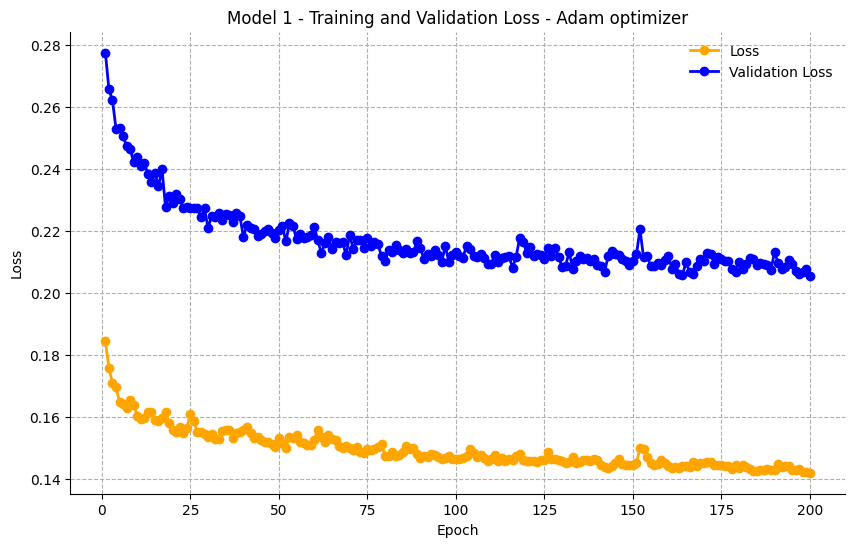

In [35]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Adam optimizer')
ax.grid(True, linestyle='--')
plt.show()

##### Nadam optimizer 20% in validation

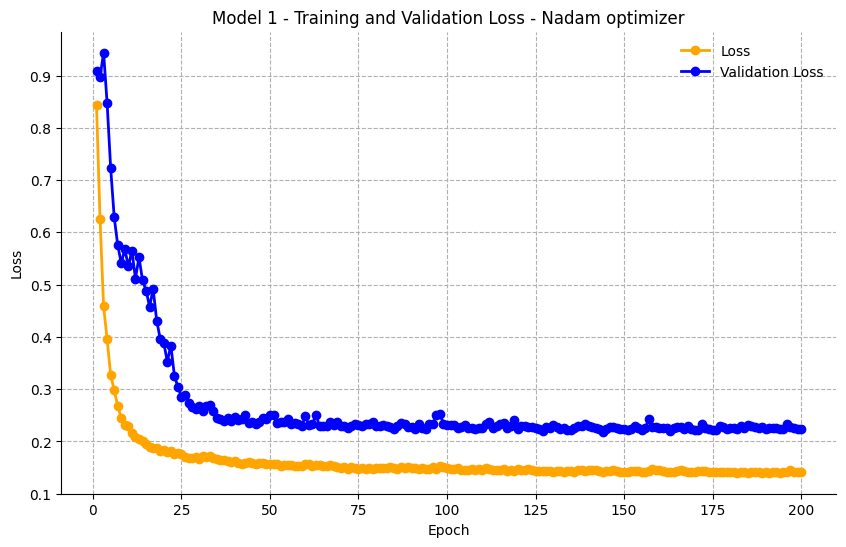

In [38]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
plt.show()

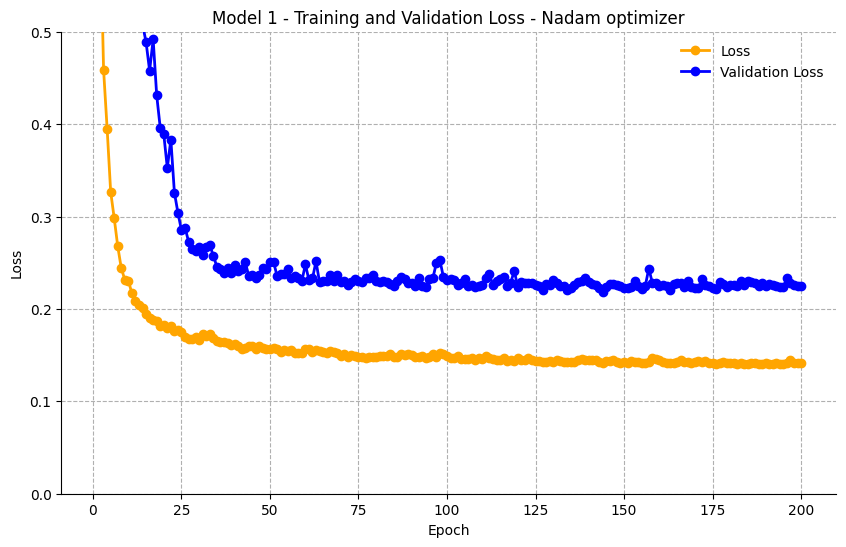

In [39]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
plt.ylim((0, 0.5))
plt.show()



##### Adam optimizer with validation data of 10%

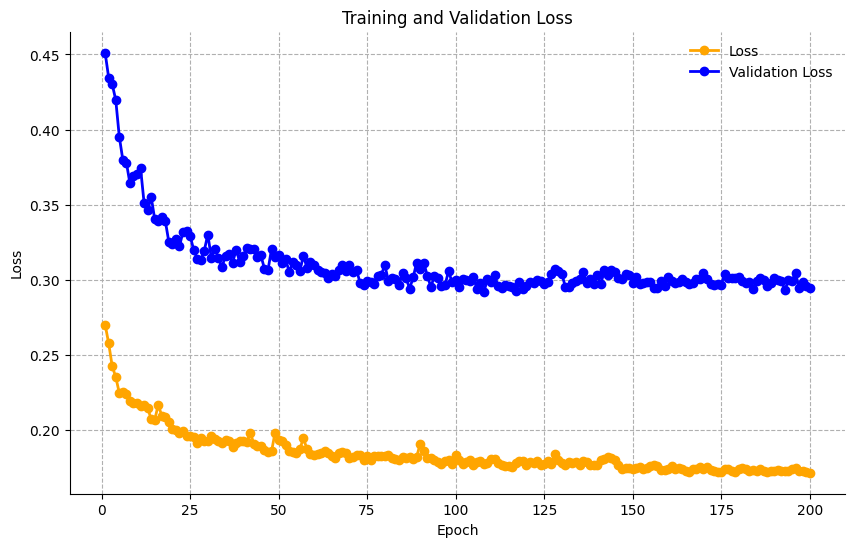

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Training and Validation Loss - Model 1 ')
ax.grid(True, linestyle='--')
plt.show()

/content/checkpoint_model_1/cp-0001.ckpt


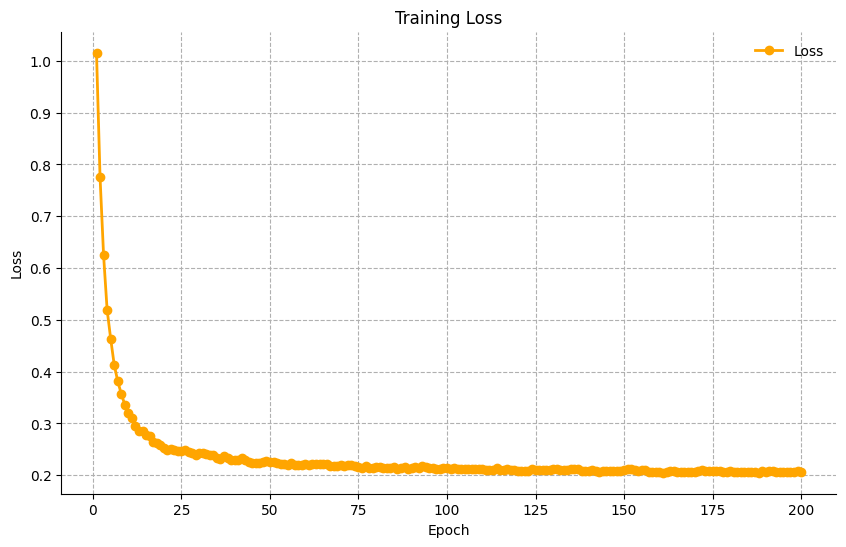

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

# Plot loss history
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

# Add title and gridlines
ax.set_title('Training Loss')
ax.grid(True, linestyle='--')

# Show the plot
plt.show()

###### ***Model 2 - Architecture***

In [40]:
def model_2(filter_base=64, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
unet_model2 = model_2()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = Nadam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model2.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_18 (Sequential)     (None, None, None,   1728        ['input_3[0][0]']                
                                None, 64)                                                         
                                                                                                  
 sequential_19 (Sequential)     (None, None, None,   221696      ['sequential_18[0][0]']          
                                None, 128)                                                  

###### ***Model 2 - Trainning the model***

In [42]:
# Directories to store the checkpoints created
checkpoint_path_2 = "checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path_2)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_2,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Train the model with validation data
loss_history_2 = []
val_loss_history_2 = []  # Store validation loss
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_2 = unet_model2.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_2.append(history_2.history["loss"][0])
        val_loss_history_2.append(history_2.history["val_loss"][0])  # Store validation loss
        
        # Clear memory after each epoch
        del history_2
        tf.keras.backend.clear_session()
        
        pbar.update(1)

# Save loss history
with open('loss_history_2.pickle', 'wb') as f:
    pickle.dump([loss_history_2, val_loss_history_2, len(loss_history_2)], f)

Training:   0%|          | 0/200 [00:00<?, ?it/s, Epoch=1]

14/14 [==============================] - ETA: 0s - loss: 0.8800
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 13s 232ms/step - loss: 0.8800 - val_loss: 1.5022


Training:   0%|          | 1/200 [00:12<42:10, 12.72s/it, Epoch=2]

13/14 [==========================>...] - ETA: 0s - loss: 0.6753
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.6731 - val_loss: 1.5198


Training:   1%|          | 2/200 [00:15<23:04,  6.99s/it, Epoch=3]

13/14 [==========================>...] - ETA: 0s - loss: 0.5419
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.5375 - val_loss: 1.4301


Training:   2%|▏         | 3/200 [00:18<16:57,  5.16s/it, Epoch=4]

13/14 [==========================>...] - ETA: 0s - loss: 0.4216
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.4210 - val_loss: 1.2429


Training:   2%|▏         | 4/200 [00:21<14:08,  4.33s/it, Epoch=5]

13/14 [==========================>...] - ETA: 0s - loss: 0.3446
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.3446 - val_loss: 0.9220


Training:   2%|▎         | 5/200 [00:24<12:31,  3.86s/it, Epoch=6]

13/14 [==========================>...] - ETA: 0s - loss: 0.3062
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.3074 - val_loss: 0.6333


Training:   3%|▎         | 6/200 [00:27<11:30,  3.56s/it, Epoch=7]

13/14 [==========================>...] - ETA: 0s - loss: 0.2723
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.2715 - val_loss: 0.5956


Training:   4%|▎         | 7/200 [00:30<10:52,  3.38s/it, Epoch=8]

13/14 [==========================>...] - ETA: 0s - loss: 0.2540
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.2514 - val_loss: 0.5137


Training:   4%|▍         | 8/200 [00:33<10:23,  3.25s/it, Epoch=9]

13/14 [==========================>...] - ETA: 0s - loss: 0.2301
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.2297 - val_loss: 0.4952


Training:   4%|▍         | 9/200 [00:36<10:02,  3.16s/it, Epoch=10]

13/14 [==========================>...] - ETA: 0s - loss: 0.2210
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.2243 - val_loss: 0.4564


Training:   5%|▌         | 10/200 [00:39<09:46,  3.09s/it, Epoch=11]

13/14 [==========================>...] - ETA: 0s - loss: 0.2183
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 224ms/step - loss: 0.2186 - val_loss: 0.4084


Training:   6%|▌         | 11/200 [00:43<10:25,  3.31s/it, Epoch=12]

13/14 [==========================>...] - ETA: 0s - loss: 0.2021
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.2045 - val_loss: 0.3485


Training:   6%|▌         | 12/200 [00:46<10:04,  3.21s/it, Epoch=13]

13/14 [==========================>...] - ETA: 0s - loss: 0.2023
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.2021 - val_loss: 0.3822


Training:   6%|▋         | 13/200 [00:49<09:45,  3.13s/it, Epoch=14]

13/14 [==========================>...] - ETA: 0s - loss: 0.1952
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1946 - val_loss: 0.3617


Training:   7%|▋         | 14/200 [00:52<09:34,  3.09s/it, Epoch=15]

13/14 [==========================>...] - ETA: 0s - loss: 0.1861
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1876 - val_loss: 0.3459


Training:   8%|▊         | 15/200 [00:55<09:25,  3.06s/it, Epoch=16]

13/14 [==========================>...] - ETA: 0s - loss: 0.1820
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1818 - val_loss: 0.3401


Training:   8%|▊         | 16/200 [00:58<09:17,  3.03s/it, Epoch=17]

13/14 [==========================>...] - ETA: 0s - loss: 0.1795
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1783 - val_loss: 0.3141


Training:   8%|▊         | 17/200 [01:01<09:10,  3.01s/it, Epoch=18]

13/14 [==========================>...] - ETA: 0s - loss: 0.1731
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1729 - val_loss: 0.3138


Training:   9%|▉         | 18/200 [01:04<09:05,  3.00s/it, Epoch=19]

13/14 [==========================>...] - ETA: 0s - loss: 0.1725
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1741 - val_loss: 0.3152


Training:  10%|▉         | 19/200 [01:07<09:02,  3.00s/it, Epoch=20]

13/14 [==========================>...] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1773 - val_loss: 0.2847


Training:  10%|█         | 20/200 [01:10<08:57,  2.99s/it, Epoch=21]

13/14 [==========================>...] - ETA: 0s - loss: 0.1735
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1726 - val_loss: 0.2887


Training:  10%|█         | 21/200 [01:13<08:55,  2.99s/it, Epoch=22]

13/14 [==========================>...] - ETA: 0s - loss: 0.1658
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1659 - val_loss: 0.2679


Training:  11%|█         | 22/200 [01:16<08:50,  2.98s/it, Epoch=23]

13/14 [==========================>...] - ETA: 0s - loss: 0.1666
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1669 - val_loss: 0.2784


Training:  12%|█▏        | 23/200 [01:19<08:49,  2.99s/it, Epoch=24]

13/14 [==========================>...] - ETA: 0s - loss: 0.1661
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1673 - val_loss: 0.2848


Training:  12%|█▏        | 24/200 [01:22<08:44,  2.98s/it, Epoch=25]

13/14 [==========================>...] - ETA: 0s - loss: 0.1684
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1695 - val_loss: 0.2572


Training:  12%|█▎        | 25/200 [01:25<08:42,  2.99s/it, Epoch=26]

13/14 [==========================>...] - ETA: 0s - loss: 0.1667
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1676 - val_loss: 0.2613


Training:  13%|█▎        | 26/200 [01:28<08:40,  2.99s/it, Epoch=27]

13/14 [==========================>...] - ETA: 0s - loss: 0.1675
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1672 - val_loss: 0.2662


Training:  14%|█▎        | 27/200 [01:31<08:36,  2.98s/it, Epoch=28]

13/14 [==========================>...] - ETA: 0s - loss: 0.1598
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1608 - val_loss: 0.2550


Training:  14%|█▍        | 28/200 [01:34<08:32,  2.98s/it, Epoch=29]

13/14 [==========================>...] - ETA: 0s - loss: 0.1623
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1629 - val_loss: 0.2518


Training:  14%|█▍        | 29/200 [01:36<08:27,  2.97s/it, Epoch=30]

13/14 [==========================>...] - ETA: 0s - loss: 0.1573
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1596 - val_loss: 0.2515


Training:  15%|█▌        | 30/200 [01:40<08:27,  2.98s/it, Epoch=31]

13/14 [==========================>...] - ETA: 0s - loss: 0.1577
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 205ms/step - loss: 0.1569 - val_loss: 0.2523


Training:  16%|█▌        | 31/200 [01:43<08:52,  3.15s/it, Epoch=32]

13/14 [==========================>...] - ETA: 0s - loss: 0.1595
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1588 - val_loss: 0.2622


Training:  16%|█▌        | 32/200 [01:46<08:39,  3.09s/it, Epoch=33]

13/14 [==========================>...] - ETA: 0s - loss: 0.1599
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1595 - val_loss: 0.2423


Training:  16%|█▋        | 33/200 [01:49<08:30,  3.05s/it, Epoch=34]

13/14 [==========================>...] - ETA: 0s - loss: 0.1579
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1578 - val_loss: 0.2431


Training:  17%|█▋        | 34/200 [01:52<08:21,  3.02s/it, Epoch=35]

13/14 [==========================>...] - ETA: 0s - loss: 0.1523
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 166ms/step - loss: 0.1538 - val_loss: 0.2415


Training:  18%|█▊        | 35/200 [01:55<08:18,  3.02s/it, Epoch=36]

13/14 [==========================>...] - ETA: 0s - loss: 0.1570
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1569 - val_loss: 0.2474


Training:  18%|█▊        | 36/200 [01:58<08:12,  3.00s/it, Epoch=37]

13/14 [==========================>...] - ETA: 0s - loss: 0.1575
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1557 - val_loss: 0.2462


Training:  18%|█▊        | 37/200 [02:01<08:07,  2.99s/it, Epoch=38]

13/14 [==========================>...] - ETA: 0s - loss: 0.1551
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1573 - val_loss: 0.2428


Training:  19%|█▉        | 38/200 [02:04<08:02,  2.98s/it, Epoch=39]

13/14 [==========================>...] - ETA: 0s - loss: 0.1588
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 186ms/step - loss: 0.1591 - val_loss: 0.2357


Training:  20%|█▉        | 39/200 [02:07<08:14,  3.07s/it, Epoch=40]

13/14 [==========================>...] - ETA: 0s - loss: 0.1587
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1582 - val_loss: 0.2479


Training:  20%|██        | 40/200 [02:10<08:05,  3.03s/it, Epoch=41]

13/14 [==========================>...] - ETA: 0s - loss: 0.1557
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1543 - val_loss: 0.2283


Training:  20%|██        | 41/200 [02:13<07:59,  3.01s/it, Epoch=42]

13/14 [==========================>...] - ETA: 0s - loss: 0.1542
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1533 - val_loss: 0.2417


Training:  21%|██        | 42/200 [02:16<07:54,  3.00s/it, Epoch=43]

13/14 [==========================>...] - ETA: 0s - loss: 0.1486
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1492 - val_loss: 0.2391


Training:  22%|██▏       | 43/200 [02:19<07:48,  2.98s/it, Epoch=44]

13/14 [==========================>...] - ETA: 0s - loss: 0.1543
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1529 - val_loss: 0.2419


Training:  22%|██▏       | 44/200 [02:22<07:42,  2.97s/it, Epoch=45]

13/14 [==========================>...] - ETA: 0s - loss: 0.1525
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 199ms/step - loss: 0.1524 - val_loss: 0.2459


Training:  22%|██▎       | 45/200 [02:25<08:02,  3.12s/it, Epoch=46]

13/14 [==========================>...] - ETA: 0s - loss: 0.1541
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 166ms/step - loss: 0.1540 - val_loss: 0.2534


Training:  23%|██▎       | 46/200 [02:29<08:22,  3.26s/it, Epoch=47]

13/14 [==========================>...] - ETA: 0s - loss: 0.1532
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 165ms/step - loss: 0.1534 - val_loss: 0.2363


Training:  24%|██▎       | 47/200 [02:32<08:28,  3.32s/it, Epoch=48]

13/14 [==========================>...] - ETA: 0s - loss: 0.1494
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1491 - val_loss: 0.2392


Training:  24%|██▍       | 48/200 [02:36<08:19,  3.29s/it, Epoch=49]

13/14 [==========================>...] - ETA: 0s - loss: 0.1554
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1565 - val_loss: 0.2377


Training:  24%|██▍       | 49/200 [02:39<08:08,  3.23s/it, Epoch=50]

13/14 [==========================>...] - ETA: 0s - loss: 0.1489
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1484 - val_loss: 0.2360


Training:  25%|██▌       | 50/200 [02:42<07:55,  3.17s/it, Epoch=51]

13/14 [==========================>...] - ETA: 0s - loss: 0.1492
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1482 - val_loss: 0.2301


Training:  26%|██▌       | 51/200 [02:45<07:47,  3.14s/it, Epoch=52]

13/14 [==========================>...] - ETA: 0s - loss: 0.1494
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1496 - val_loss: 0.2351


Training:  26%|██▌       | 52/200 [02:48<07:37,  3.09s/it, Epoch=53]

13/14 [==========================>...] - ETA: 0s - loss: 0.1466
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1467 - val_loss: 0.2380


Training:  26%|██▋       | 53/200 [02:51<07:29,  3.06s/it, Epoch=54]

13/14 [==========================>...] - ETA: 0s - loss: 0.1501
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1504 - val_loss: 0.2327


Training:  27%|██▋       | 54/200 [02:54<07:23,  3.04s/it, Epoch=55]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 179ms/step - loss: 0.1489 - val_loss: 0.2277


Training:  28%|██▊       | 55/200 [02:57<07:28,  3.09s/it, Epoch=56]

13/14 [==========================>...] - ETA: 0s - loss: 0.1477
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1485 - val_loss: 0.2322


Training:  28%|██▊       | 56/200 [03:00<07:19,  3.05s/it, Epoch=57]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1471 - val_loss: 0.2397


Training:  28%|██▊       | 57/200 [03:03<07:12,  3.03s/it, Epoch=58]

13/14 [==========================>...] - ETA: 0s - loss: 0.1513
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1526 - val_loss: 0.2314


Training:  29%|██▉       | 58/200 [03:06<07:06,  3.01s/it, Epoch=59]

13/14 [==========================>...] - ETA: 0s - loss: 0.1506
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 188ms/step - loss: 0.1486 - val_loss: 0.2487


Training:  30%|██▉       | 59/200 [03:09<07:17,  3.10s/it, Epoch=60]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1481 - val_loss: 0.2383


Training:  30%|███       | 60/200 [03:12<07:08,  3.06s/it, Epoch=61]

13/14 [==========================>...] - ETA: 0s - loss: 0.1469
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1455 - val_loss: 0.2443


Training:  30%|███       | 61/200 [03:15<07:03,  3.05s/it, Epoch=62]

13/14 [==========================>...] - ETA: 0s - loss: 0.1471
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1466 - val_loss: 0.2293


Training:  31%|███       | 62/200 [03:18<06:58,  3.04s/it, Epoch=63]

13/14 [==========================>...] - ETA: 0s - loss: 0.1446
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1446 - val_loss: 0.2269


Training:  32%|███▏      | 63/200 [03:21<06:55,  3.03s/it, Epoch=64]

13/14 [==========================>...] - ETA: 0s - loss: 0.1470
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1459 - val_loss: 0.2358


Training:  32%|███▏      | 64/200 [03:24<06:50,  3.02s/it, Epoch=65]

13/14 [==========================>...] - ETA: 0s - loss: 0.1421
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1450 - val_loss: 0.2280


Training:  32%|███▎      | 65/200 [03:27<06:45,  3.00s/it, Epoch=66]

13/14 [==========================>...] - ETA: 0s - loss: 0.1437
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1431 - val_loss: 0.2282


Training:  33%|███▎      | 66/200 [03:30<06:40,  2.99s/it, Epoch=67]

13/14 [==========================>...] - ETA: 0s - loss: 0.1440
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1439 - val_loss: 0.2252


Training:  34%|███▎      | 67/200 [03:33<06:37,  2.99s/it, Epoch=68]

13/14 [==========================>...] - ETA: 0s - loss: 0.1446
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1443 - val_loss: 0.2384


Training:  34%|███▍      | 68/200 [03:36<06:34,  2.99s/it, Epoch=69]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1463 - val_loss: 0.2350


Training:  34%|███▍      | 69/200 [03:39<06:29,  2.98s/it, Epoch=70]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1453 - val_loss: 0.2350


Training:  35%|███▌      | 70/200 [03:42<06:27,  2.98s/it, Epoch=71]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1471 - val_loss: 0.2253


Training:  36%|███▌      | 71/200 [03:45<06:26,  2.99s/it, Epoch=72]

13/14 [==========================>...] - ETA: 0s - loss: 0.1443
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1431 - val_loss: 0.2352


Training:  36%|███▌      | 72/200 [03:48<06:24,  3.00s/it, Epoch=73]

13/14 [==========================>...] - ETA: 0s - loss: 0.1444
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 165ms/step - loss: 0.1440 - val_loss: 0.2491


Training:  36%|███▋      | 73/200 [03:51<06:23,  3.02s/it, Epoch=74]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1454 - val_loss: 0.2338


Training:  37%|███▋      | 74/200 [03:54<06:19,  3.01s/it, Epoch=75]

13/14 [==========================>...] - ETA: 0s - loss: 0.1459
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 175ms/step - loss: 0.1455 - val_loss: 0.2393


Training:  38%|███▊      | 75/200 [03:57<06:23,  3.07s/it, Epoch=76]

13/14 [==========================>...] - ETA: 0s - loss: 0.1477
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1480 - val_loss: 0.2315


Training:  38%|███▊      | 76/200 [04:00<06:17,  3.05s/it, Epoch=77]

13/14 [==========================>...] - ETA: 0s - loss: 0.1411
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1435 - val_loss: 0.2550


Training:  38%|███▊      | 77/200 [04:03<06:12,  3.03s/it, Epoch=78]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1439 - val_loss: 0.2370


Training:  39%|███▉      | 78/200 [04:06<06:05,  3.00s/it, Epoch=79]

13/14 [==========================>...] - ETA: 0s - loss: 0.1441
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1429 - val_loss: 0.2284


Training:  40%|███▉      | 79/200 [04:09<06:01,  2.99s/it, Epoch=80]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1468 - val_loss: 0.2261


Training:  40%|████      | 80/200 [04:12<05:57,  2.98s/it, Epoch=81]

13/14 [==========================>...] - ETA: 0s - loss: 0.1432
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1437 - val_loss: 0.2254


Training:  40%|████      | 81/200 [04:15<05:53,  2.97s/it, Epoch=82]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1409 - val_loss: 0.2249


Training:  41%|████      | 82/200 [04:18<05:50,  2.97s/it, Epoch=83]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1419 - val_loss: 0.2290


Training:  42%|████▏     | 83/200 [04:21<05:48,  2.97s/it, Epoch=84]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1416 - val_loss: 0.2273


Training:  42%|████▏     | 84/200 [04:24<05:43,  2.96s/it, Epoch=85]

13/14 [==========================>...] - ETA: 0s - loss: 0.1428
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1436 - val_loss: 0.2248


Training:  42%|████▎     | 85/200 [04:27<05:39,  2.96s/it, Epoch=86]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1412 - val_loss: 0.2265


Training:  43%|████▎     | 86/200 [04:30<05:37,  2.96s/it, Epoch=87]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1412 - val_loss: 0.2355


Training:  44%|████▎     | 87/200 [04:33<05:34,  2.96s/it, Epoch=88]

13/14 [==========================>...] - ETA: 0s - loss: 0.1435
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1424 - val_loss: 0.2283


Training:  44%|████▍     | 88/200 [04:36<05:30,  2.95s/it, Epoch=89]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 184ms/step - loss: 0.1405 - val_loss: 0.2266


Training:  44%|████▍     | 89/200 [04:39<05:37,  3.04s/it, Epoch=90]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1412 - val_loss: 0.2265


Training:  45%|████▌     | 90/200 [04:42<05:32,  3.02s/it, Epoch=91]

13/14 [==========================>...] - ETA: 0s - loss: 0.1424
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1437 - val_loss: 0.2319


Training:  46%|████▌     | 91/200 [04:45<05:27,  3.00s/it, Epoch=92]

13/14 [==========================>...] - ETA: 0s - loss: 0.1458
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1451 - val_loss: 0.2356


Training:  46%|████▌     | 92/200 [04:48<05:21,  2.98s/it, Epoch=93]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1417 - val_loss: 0.2260


Training:  46%|████▋     | 93/200 [04:51<05:17,  2.97s/it, Epoch=94]

13/14 [==========================>...] - ETA: 0s - loss: 0.1446
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1437 - val_loss: 0.2296


Training:  47%|████▋     | 94/200 [04:54<05:15,  2.97s/it, Epoch=95]

13/14 [==========================>...] - ETA: 0s - loss: 0.1385
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 184ms/step - loss: 0.1403 - val_loss: 0.2275


Training:  48%|████▊     | 95/200 [04:57<05:21,  3.06s/it, Epoch=96]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1398 - val_loss: 0.2266


Training:  48%|████▊     | 96/200 [05:00<05:15,  3.03s/it, Epoch=97]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1410 - val_loss: 0.2290


Training:  48%|████▊     | 97/200 [05:03<05:09,  3.00s/it, Epoch=98]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1411 - val_loss: 0.2319


Training:  49%|████▉     | 98/200 [05:06<05:04,  2.99s/it, Epoch=99]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1395 - val_loss: 0.2288


Training:  50%|████▉     | 99/200 [05:09<05:02,  2.99s/it, Epoch=100]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1397 - val_loss: 0.2286


Training:  50%|█████     | 100/200 [05:12<05:02,  3.02s/it, Epoch=101]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1431 - val_loss: 0.2571


Training:  50%|█████     | 101/200 [05:15<04:59,  3.02s/it, Epoch=102]

13/14 [==========================>...] - ETA: 0s - loss: 0.1501
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1490 - val_loss: 0.2320


Training:  51%|█████     | 102/200 [05:18<04:54,  3.01s/it, Epoch=103]

13/14 [==========================>...] - ETA: 0s - loss: 0.1458
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1449 - val_loss: 0.2286


Training:  52%|█████▏    | 103/200 [05:21<04:50,  2.99s/it, Epoch=104]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1424 - val_loss: 0.2374


Training:  52%|█████▏    | 104/200 [05:24<04:46,  2.98s/it, Epoch=105]

13/14 [==========================>...] - ETA: 0s - loss: 0.1479
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 189ms/step - loss: 0.1483 - val_loss: 0.2458


Training:  52%|█████▎    | 105/200 [05:27<04:53,  3.09s/it, Epoch=106]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1451 - val_loss: 0.2318


Training:  53%|█████▎    | 106/200 [05:30<04:47,  3.06s/it, Epoch=107]

13/14 [==========================>...] - ETA: 0s - loss: 0.1432
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1423 - val_loss: 0.2309


Training:  54%|█████▎    | 107/200 [05:33<04:43,  3.05s/it, Epoch=108]

13/14 [==========================>...] - ETA: 0s - loss: 0.1374
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1408 - val_loss: 0.2327


Training:  54%|█████▍    | 108/200 [05:36<04:40,  3.04s/it, Epoch=109]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 169ms/step - loss: 0.1465 - val_loss: 0.2293


Training:  55%|█████▍    | 109/200 [05:39<04:37,  3.05s/it, Epoch=110]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1419 - val_loss: 0.2324


Training:  55%|█████▌    | 110/200 [05:42<04:31,  3.02s/it, Epoch=111]

13/14 [==========================>...] - ETA: 0s - loss: 0.1373
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1397 - val_loss: 0.2397


Training:  56%|█████▌    | 111/200 [05:45<04:26,  3.00s/it, Epoch=112]

13/14 [==========================>...] - ETA: 0s - loss: 0.1463
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1467 - val_loss: 0.2360


Training:  56%|█████▌    | 112/200 [05:48<04:22,  2.98s/it, Epoch=113]

13/14 [==========================>...] - ETA: 0s - loss: 0.1440
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1435 - val_loss: 0.2293


Training:  56%|█████▋    | 113/200 [05:51<04:20,  2.99s/it, Epoch=114]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1403 - val_loss: 0.2352


Training:  57%|█████▋    | 114/200 [05:54<04:15,  2.97s/it, Epoch=115]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1393 - val_loss: 0.2263


Training:  57%|█████▊    | 115/200 [05:57<04:11,  2.96s/it, Epoch=116]

13/14 [==========================>...] - ETA: 0s - loss: 0.1392
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1410 - val_loss: 0.2251


Training:  58%|█████▊    | 116/200 [06:00<04:07,  2.95s/it, Epoch=117]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1440 - val_loss: 0.2267


Training:  58%|█████▊    | 117/200 [06:03<04:05,  2.95s/it, Epoch=118]

13/14 [==========================>...] - ETA: 0s - loss: 0.1416
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1416 - val_loss: 0.2451


Training:  59%|█████▉    | 118/200 [06:06<04:02,  2.95s/it, Epoch=119]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1415 - val_loss: 0.2233


Training:  60%|█████▉    | 119/200 [06:09<03:58,  2.95s/it, Epoch=120]

13/14 [==========================>...] - ETA: 0s - loss: 0.1376
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1389 - val_loss: 0.2227


Training:  60%|██████    | 120/200 [06:12<03:55,  2.95s/it, Epoch=121]

13/14 [==========================>...] - ETA: 0s - loss: 0.1377
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1389 - val_loss: 0.2212


Training:  60%|██████    | 121/200 [06:15<03:53,  2.95s/it, Epoch=122]

13/14 [==========================>...] - ETA: 0s - loss: 0.1344
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1377 - val_loss: 0.2191


Training:  61%|██████    | 122/200 [06:18<03:50,  2.95s/it, Epoch=123]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1395 - val_loss: 0.2276


Training:  62%|██████▏   | 123/200 [06:21<03:46,  2.94s/it, Epoch=124]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1386 - val_loss: 0.2205


Training:  62%|██████▏   | 124/200 [06:24<03:43,  2.94s/it, Epoch=125]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1371 - val_loss: 0.2230


Training:  62%|██████▎   | 125/200 [06:27<03:41,  2.95s/it, Epoch=126]

13/14 [==========================>...] - ETA: 0s - loss: 0.1349
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1375 - val_loss: 0.2234


Training:  63%|██████▎   | 126/200 [06:29<03:37,  2.94s/it, Epoch=127]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1384 - val_loss: 0.2247


Training:  64%|██████▎   | 127/200 [06:32<03:35,  2.95s/it, Epoch=128]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1389 - val_loss: 0.2265


Training:  64%|██████▍   | 128/200 [06:35<03:31,  2.94s/it, Epoch=129]

13/14 [==========================>...] - ETA: 0s - loss: 0.1371
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 166ms/step - loss: 0.1380 - val_loss: 0.2246


Training:  64%|██████▍   | 129/200 [06:38<03:30,  2.97s/it, Epoch=130]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1371 - val_loss: 0.2233


Training:  65%|██████▌   | 130/200 [06:41<03:27,  2.96s/it, Epoch=131]

13/14 [==========================>...] - ETA: 0s - loss: 0.1356
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1383 - val_loss: 0.2266


Training:  66%|██████▌   | 131/200 [06:44<03:24,  2.96s/it, Epoch=132]

13/14 [==========================>...] - ETA: 0s - loss: 0.1402
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1395 - val_loss: 0.2287


Training:  66%|██████▌   | 132/200 [06:47<03:20,  2.95s/it, Epoch=133]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1387 - val_loss: 0.2209


Training:  66%|██████▋   | 133/200 [06:50<03:17,  2.95s/it, Epoch=134]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1382 - val_loss: 0.2210


Training:  67%|██████▋   | 134/200 [06:53<03:14,  2.95s/it, Epoch=135]

13/14 [==========================>...] - ETA: 0s - loss: 0.1365
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1374 - val_loss: 0.2182


Training:  68%|██████▊   | 135/200 [06:56<03:11,  2.95s/it, Epoch=136]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1384 - val_loss: 0.2206


Training:  68%|██████▊   | 136/200 [06:59<03:08,  2.95s/it, Epoch=137]

13/14 [==========================>...] - ETA: 0s - loss: 0.1381
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1374 - val_loss: 0.2215


Training:  68%|██████▊   | 137/200 [07:02<03:06,  2.95s/it, Epoch=138]

13/14 [==========================>...] - ETA: 0s - loss: 0.1375
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1368 - val_loss: 0.2193


Training:  69%|██████▉   | 138/200 [07:05<03:03,  2.95s/it, Epoch=139]

13/14 [==========================>...] - ETA: 0s - loss: 0.1366
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1383 - val_loss: 0.2244


Training:  70%|██████▉   | 139/200 [07:08<03:01,  2.98s/it, Epoch=140]

13/14 [==========================>...] - ETA: 0s - loss: 0.1369
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1365 - val_loss: 0.2240


Training:  70%|███████   | 140/200 [07:11<02:58,  2.98s/it, Epoch=141]

13/14 [==========================>...] - ETA: 0s - loss: 0.1354
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1359 - val_loss: 0.2256


Training:  70%|███████   | 141/200 [07:14<02:55,  2.97s/it, Epoch=142]

13/14 [==========================>...] - ETA: 0s - loss: 0.1377
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1368 - val_loss: 0.2226


Training:  71%|███████   | 142/200 [07:17<02:52,  2.97s/it, Epoch=143]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1380 - val_loss: 0.2227


Training:  72%|███████▏  | 143/200 [07:20<02:49,  2.97s/it, Epoch=144]

13/14 [==========================>...] - ETA: 0s - loss: 0.1371
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1367 - val_loss: 0.2205


Training:  72%|███████▏  | 144/200 [07:23<02:46,  2.97s/it, Epoch=145]

13/14 [==========================>...] - ETA: 0s - loss: 0.1375
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1374 - val_loss: 0.2251


Training:  72%|███████▎  | 145/200 [07:26<02:43,  2.97s/it, Epoch=146]

13/14 [==========================>...] - ETA: 0s - loss: 0.1379
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1369 - val_loss: 0.2260


Training:  73%|███████▎  | 146/200 [07:29<02:39,  2.96s/it, Epoch=147]

13/14 [==========================>...] - ETA: 0s - loss: 0.1358
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 174ms/step - loss: 0.1362 - val_loss: 0.2245


Training:  74%|███████▎  | 147/200 [07:32<02:39,  3.01s/it, Epoch=148]

13/14 [==========================>...] - ETA: 0s - loss: 0.1357
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1362 - val_loss: 0.2327


Training:  74%|███████▍  | 148/200 [07:35<02:35,  3.00s/it, Epoch=149]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1395 - val_loss: 0.2246


Training:  74%|███████▍  | 149/200 [07:38<02:32,  2.99s/it, Epoch=150]

13/14 [==========================>...] - ETA: 0s - loss: 0.1365
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1374 - val_loss: 0.2307


Training:  75%|███████▌  | 150/200 [07:41<02:29,  2.99s/it, Epoch=151]

13/14 [==========================>...] - ETA: 0s - loss: 0.1364
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1365 - val_loss: 0.2245


Training:  76%|███████▌  | 151/200 [07:44<02:25,  2.97s/it, Epoch=152]

13/14 [==========================>...] - ETA: 0s - loss: 0.1363
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1372 - val_loss: 0.2232


Training:  76%|███████▌  | 152/200 [07:47<02:22,  2.97s/it, Epoch=153]

13/14 [==========================>...] - ETA: 0s - loss: 0.1363
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1372 - val_loss: 0.2256


Training:  76%|███████▋  | 153/200 [07:50<02:19,  2.98s/it, Epoch=154]

13/14 [==========================>...] - ETA: 0s - loss: 0.1371
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1368 - val_loss: 0.2180


Training:  77%|███████▋  | 154/200 [07:53<02:16,  2.98s/it, Epoch=155]

13/14 [==========================>...] - ETA: 0s - loss: 0.1361
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 182ms/step - loss: 0.1360 - val_loss: 0.2232


Training:  78%|███████▊  | 155/200 [07:56<02:17,  3.07s/it, Epoch=156]

13/14 [==========================>...] - ETA: 0s - loss: 0.1344
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1374 - val_loss: 0.2205


Training:  78%|███████▊  | 156/200 [07:59<02:13,  3.04s/it, Epoch=157]

13/14 [==========================>...] - ETA: 0s - loss: 0.1366
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1365 - val_loss: 0.2239


Training:  78%|███████▊  | 157/200 [08:02<02:10,  3.03s/it, Epoch=158]

13/14 [==========================>...] - ETA: 0s - loss: 0.1376
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1370 - val_loss: 0.2238


Training:  79%|███████▉  | 158/200 [08:05<02:06,  3.01s/it, Epoch=159]

13/14 [==========================>...] - ETA: 0s - loss: 0.1361
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 185ms/step - loss: 0.1371 - val_loss: 0.2225


Training:  80%|███████▉  | 159/200 [08:08<02:06,  3.09s/it, Epoch=160]

13/14 [==========================>...] - ETA: 0s - loss: 0.1355
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1358 - val_loss: 0.2211


Training:  80%|████████  | 160/200 [08:11<02:03,  3.09s/it, Epoch=161]

13/14 [==========================>...] - ETA: 0s - loss: 0.1367
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1355 - val_loss: 0.2226


Training:  80%|████████  | 161/200 [08:14<01:59,  3.08s/it, Epoch=162]

13/14 [==========================>...] - ETA: 0s - loss: 0.1376
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1368 - val_loss: 0.2208


Training:  81%|████████  | 162/200 [08:17<01:56,  3.06s/it, Epoch=163]

13/14 [==========================>...] - ETA: 0s - loss: 0.1354
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1356 - val_loss: 0.2245


Training:  82%|████████▏ | 163/200 [08:20<01:52,  3.05s/it, Epoch=164]

13/14 [==========================>...] - ETA: 0s - loss: 0.1357
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1363 - val_loss: 0.2297


Training:  82%|████████▏ | 164/200 [08:23<01:49,  3.04s/it, Epoch=165]

13/14 [==========================>...] - ETA: 0s - loss: 0.1358
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1357 - val_loss: 0.2222


Training:  82%|████████▎ | 165/200 [08:26<01:45,  3.01s/it, Epoch=166]

13/14 [==========================>...] - ETA: 0s - loss: 0.1357
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1358 - val_loss: 0.2236


Training:  83%|████████▎ | 166/200 [08:29<01:42,  3.01s/it, Epoch=167]

13/14 [==========================>...] - ETA: 0s - loss: 0.1338
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1354 - val_loss: 0.2200


Training:  84%|████████▎ | 167/200 [08:32<01:39,  3.02s/it, Epoch=168]

13/14 [==========================>...] - ETA: 0s - loss: 0.1360
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1353 - val_loss: 0.2219


Training:  84%|████████▍ | 168/200 [08:35<01:36,  3.02s/it, Epoch=169]

13/14 [==========================>...] - ETA: 0s - loss: 0.1357
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1348 - val_loss: 0.2189


Training:  84%|████████▍ | 169/200 [08:38<01:33,  3.00s/it, Epoch=170]

13/14 [==========================>...] - ETA: 0s - loss: 0.1355
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1347 - val_loss: 0.2221


Training:  85%|████████▌ | 170/200 [08:41<01:30,  3.01s/it, Epoch=171]

13/14 [==========================>...] - ETA: 0s - loss: 0.1339
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1359 - val_loss: 0.2219


Training:  86%|████████▌ | 171/200 [08:44<01:27,  3.01s/it, Epoch=172]

13/14 [==========================>...] - ETA: 0s - loss: 0.1337
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1358 - val_loss: 0.2217


Training:  86%|████████▌ | 172/200 [08:47<01:24,  3.01s/it, Epoch=173]

13/14 [==========================>...] - ETA: 0s - loss: 0.1342
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1358 - val_loss: 0.2235


Training:  86%|████████▋ | 173/200 [08:50<01:21,  3.02s/it, Epoch=174]

13/14 [==========================>...] - ETA: 0s - loss: 0.1359
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1354 - val_loss: 0.2196


Training:  87%|████████▋ | 174/200 [08:53<01:18,  3.02s/it, Epoch=175]

13/14 [==========================>...] - ETA: 0s - loss: 0.1358
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1364 - val_loss: 0.2393


Training:  88%|████████▊ | 175/200 [08:56<01:15,  3.02s/it, Epoch=176]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1400 - val_loss: 0.2192


Training:  88%|████████▊ | 176/200 [08:59<01:12,  3.02s/it, Epoch=177]

13/14 [==========================>...] - ETA: 0s - loss: 0.1378
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1370 - val_loss: 0.2250


Training:  88%|████████▊ | 177/200 [09:02<01:09,  3.02s/it, Epoch=178]

13/14 [==========================>...] - ETA: 0s - loss: 0.1352
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1355 - val_loss: 0.2209


Training:  89%|████████▉ | 178/200 [09:06<01:06,  3.02s/it, Epoch=179]

13/14 [==========================>...] - ETA: 0s - loss: 0.1366
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1361 - val_loss: 0.2251


Training:  90%|████████▉ | 179/200 [09:09<01:03,  3.03s/it, Epoch=180]

13/14 [==========================>...] - ETA: 0s - loss: 0.1350
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1348 - val_loss: 0.2225


Training:  90%|█████████ | 180/200 [09:12<01:00,  3.03s/it, Epoch=181]

13/14 [==========================>...] - ETA: 0s - loss: 0.1337
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1342 - val_loss: 0.2208


Training:  90%|█████████ | 181/200 [09:15<00:57,  3.02s/it, Epoch=182]

13/14 [==========================>...] - ETA: 0s - loss: 0.1348
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1355 - val_loss: 0.2318


Training:  91%|█████████ | 182/200 [09:18<00:54,  3.03s/it, Epoch=183]

13/14 [==========================>...] - ETA: 0s - loss: 0.1348
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1355 - val_loss: 0.2239


Training:  92%|█████████▏| 183/200 [09:21<00:51,  3.01s/it, Epoch=184]

13/14 [==========================>...] - ETA: 0s - loss: 0.1337
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1351 - val_loss: 0.2206


Training:  92%|█████████▏| 184/200 [09:24<00:48,  3.02s/it, Epoch=185]

13/14 [==========================>...] - ETA: 0s - loss: 0.1334
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 186ms/step - loss: 0.1353 - val_loss: 0.2215


Training:  92%|█████████▎| 185/200 [09:27<00:46,  3.12s/it, Epoch=186]

13/14 [==========================>...] - ETA: 0s - loss: 0.1359
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1356 - val_loss: 0.2233


Training:  93%|█████████▎| 186/200 [09:30<00:43,  3.09s/it, Epoch=187]

13/14 [==========================>...] - ETA: 0s - loss: 0.1347
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1342 - val_loss: 0.2215


Training:  94%|█████████▎| 187/200 [09:33<00:40,  3.08s/it, Epoch=188]

13/14 [==========================>...] - ETA: 0s - loss: 0.1348
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1347 - val_loss: 0.2227


Training:  94%|█████████▍| 188/200 [09:36<00:36,  3.05s/it, Epoch=189]

13/14 [==========================>...] - ETA: 0s - loss: 0.1343
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 184ms/step - loss: 0.1350 - val_loss: 0.2208


Training:  94%|█████████▍| 189/200 [09:39<00:34,  3.13s/it, Epoch=190]

13/14 [==========================>...] - ETA: 0s - loss: 0.1360
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 184ms/step - loss: 0.1363 - val_loss: 0.2230


Training:  95%|█████████▌| 190/200 [09:43<00:31,  3.19s/it, Epoch=191]

13/14 [==========================>...] - ETA: 0s - loss: 0.1341
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1346 - val_loss: 0.2267


Training:  96%|█████████▌| 191/200 [09:46<00:28,  3.13s/it, Epoch=192]

13/14 [==========================>...] - ETA: 0s - loss: 0.1306
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 178ms/step - loss: 0.1341 - val_loss: 0.2225


Training:  96%|█████████▌| 192/200 [09:49<00:25,  3.16s/it, Epoch=193]

13/14 [==========================>...] - ETA: 0s - loss: 0.1352
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1342 - val_loss: 0.2208


Training:  96%|█████████▋| 193/200 [09:52<00:21,  3.13s/it, Epoch=194]

13/14 [==========================>...] - ETA: 0s - loss: 0.1342
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1340 - val_loss: 0.2214


Training:  97%|█████████▋| 194/200 [09:55<00:18,  3.09s/it, Epoch=195]

13/14 [==========================>...] - ETA: 0s - loss: 0.1340
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 209ms/step - loss: 0.1339 - val_loss: 0.2255


Training:  98%|█████████▊| 195/200 [09:59<00:16,  3.25s/it, Epoch=196]

13/14 [==========================>...] - ETA: 0s - loss: 0.1355
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 176ms/step - loss: 0.1342 - val_loss: 0.2222


Training:  98%|█████████▊| 196/200 [10:03<00:14,  3.55s/it, Epoch=197]

13/14 [==========================>...] - ETA: 0s - loss: 0.1358
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 173ms/step - loss: 0.1344 - val_loss: 0.2296


Training:  98%|█████████▊| 197/200 [10:07<00:11,  3.73s/it, Epoch=198]

13/14 [==========================>...] - ETA: 0s - loss: 0.1352
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 166ms/step - loss: 0.1355 - val_loss: 0.2254


Training:  99%|█████████▉| 198/200 [10:11<00:07,  3.75s/it, Epoch=199]

13/14 [==========================>...] - ETA: 0s - loss: 0.1332
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1349 - val_loss: 0.2228


Training: 100%|█████████▉| 199/200 [10:14<00:03,  3.70s/it, Epoch=200]

13/14 [==========================>...] - ETA: 0s - loss: 0.1323
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1344 - val_loss: 0.2201


Training: 100%|██████████| 200/200 [10:18<00:00,  3.09s/it, Epoch=200]


##### Adam optimizer 20% validation data

/content/checkpoint_model_2/cp-0001.ckpt


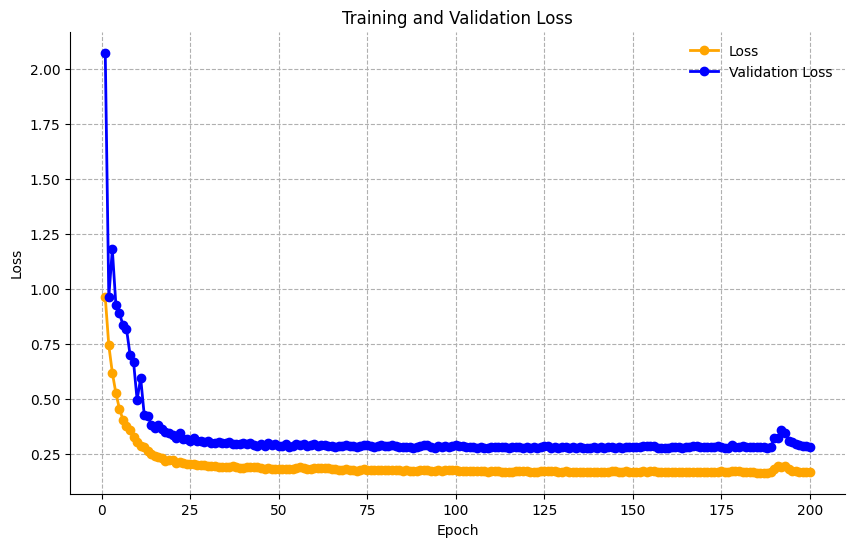

In [ ]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Training and Validation Loss')
ax.grid(True, linestyle='--')
plt.show()

##### Adam no validation data

/content/checkpoint_model_2/cp-0001.ckpt


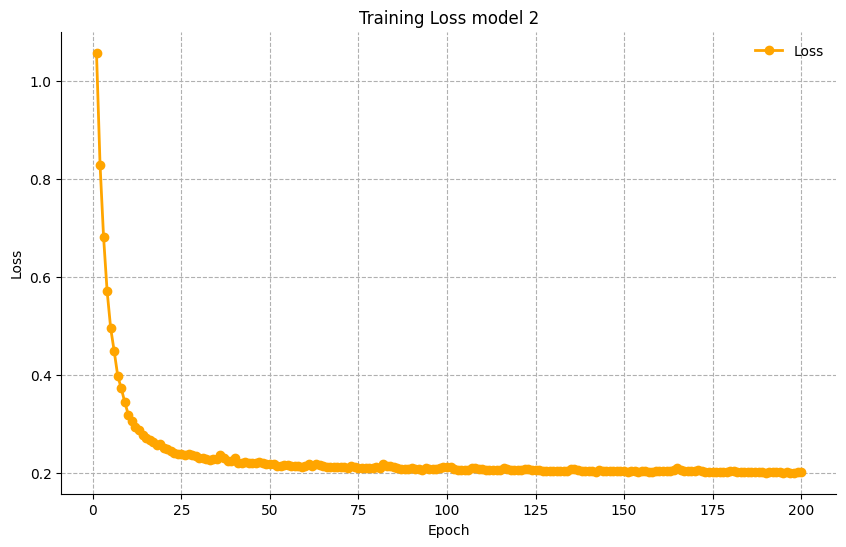

In [ ]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Training and Validation Loss')
ax.grid(True, linestyle='--')
plt.show()

##### Nadan optimizer with 20% of validation data

/content/checkpoint_model_2/cp-0001.ckpt


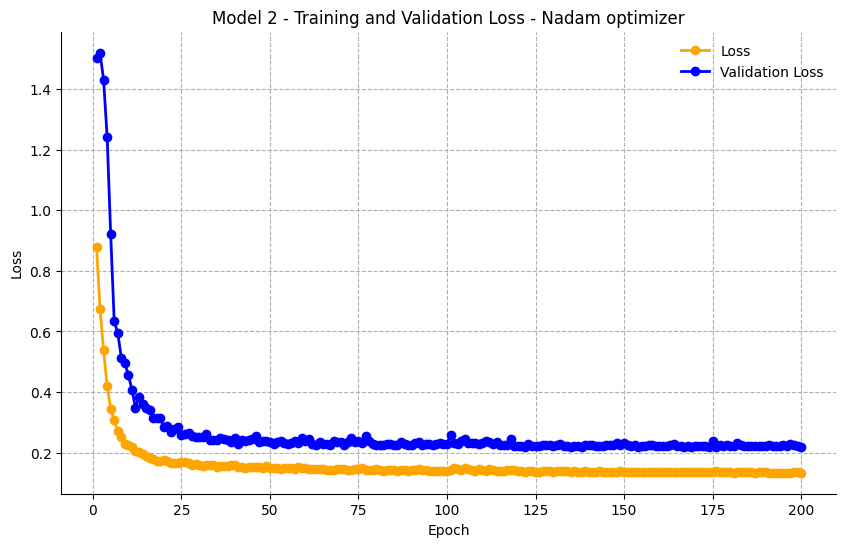

In [43]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 2 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
#plt.ylim((0, 0.5))
plt.show()

/content/checkpoint_model_2/cp-0001.ckpt


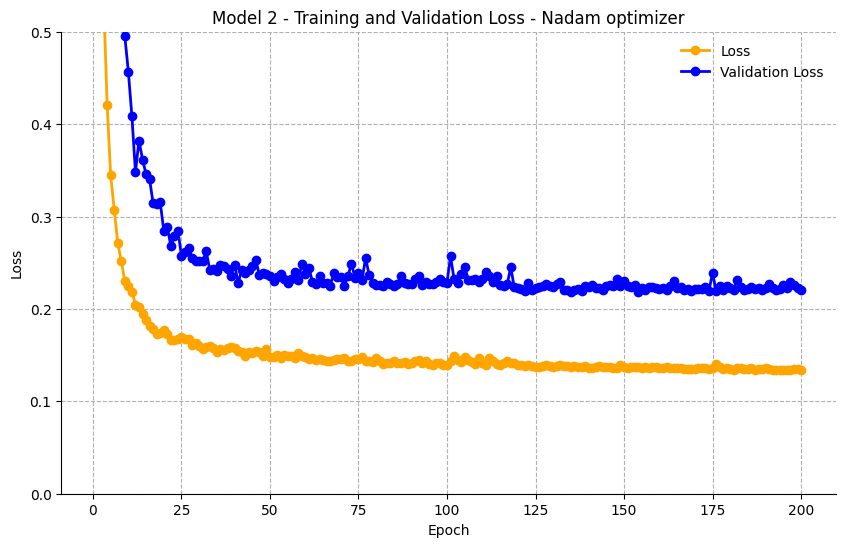

In [44]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 2 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
plt.ylim((0, 0.5))
plt.show()

##### ***Architecture Comparison Adam optimizer***

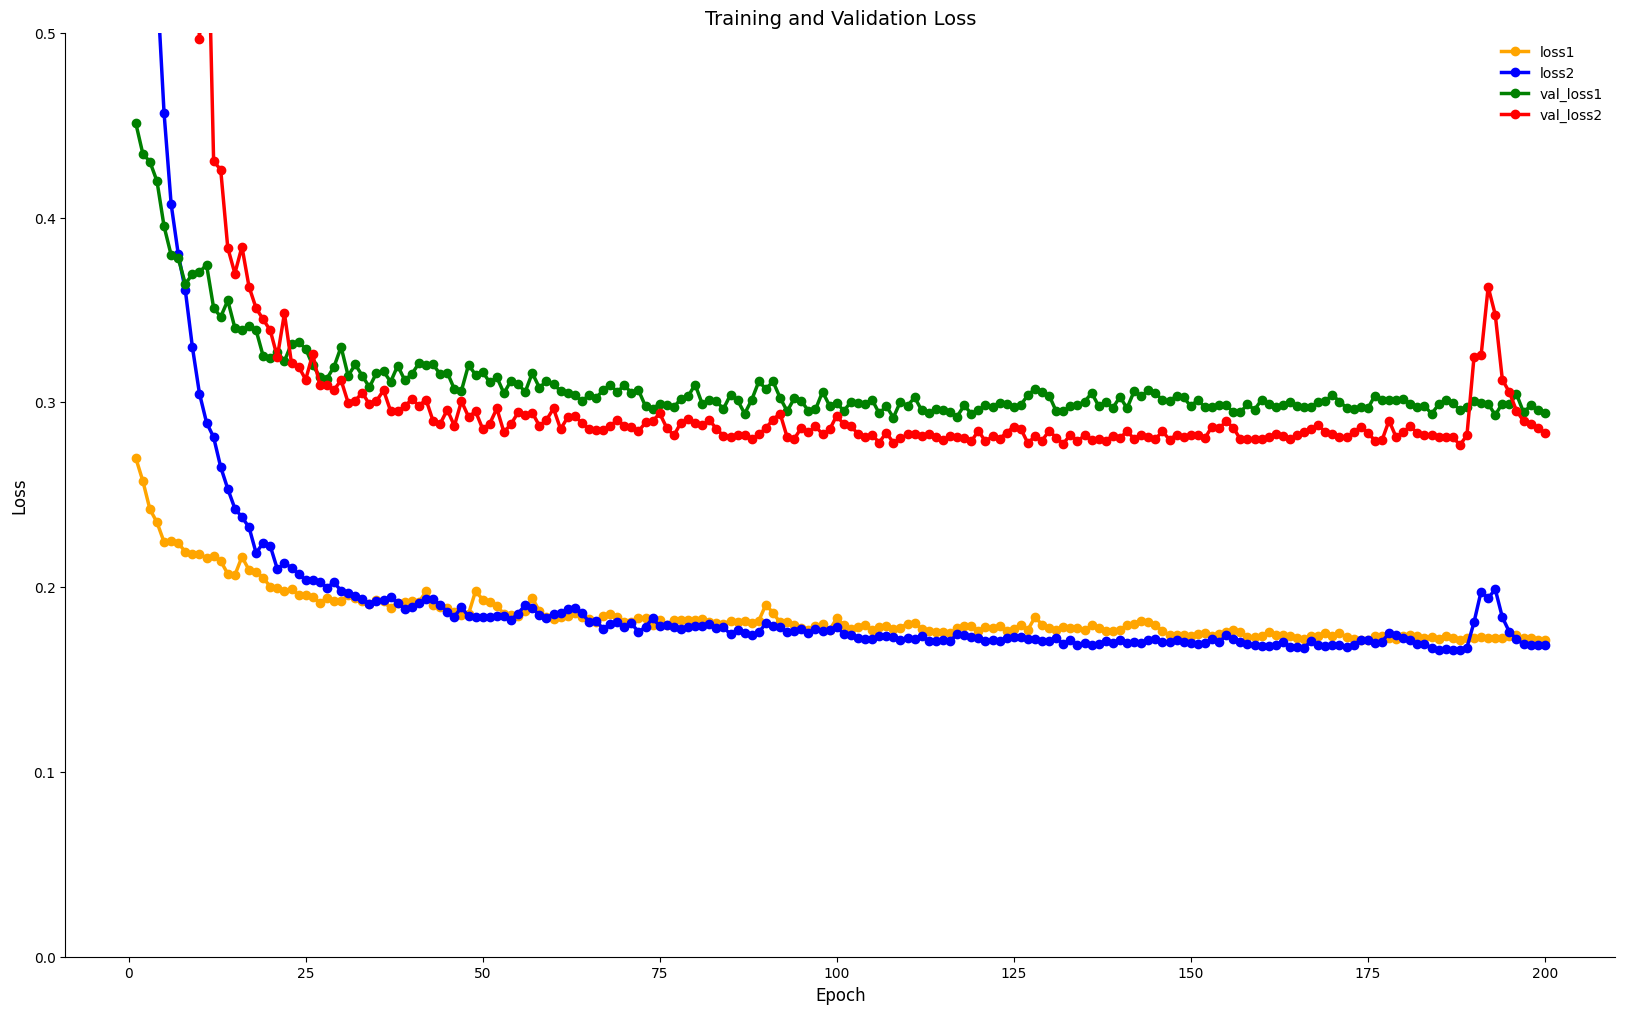

In [ ]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, val_loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, val_loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2.5, color="green", label="val_loss1")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2.5, color="red", label="val_loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()

##### ***Architecture Comparison Nadam optimizer***

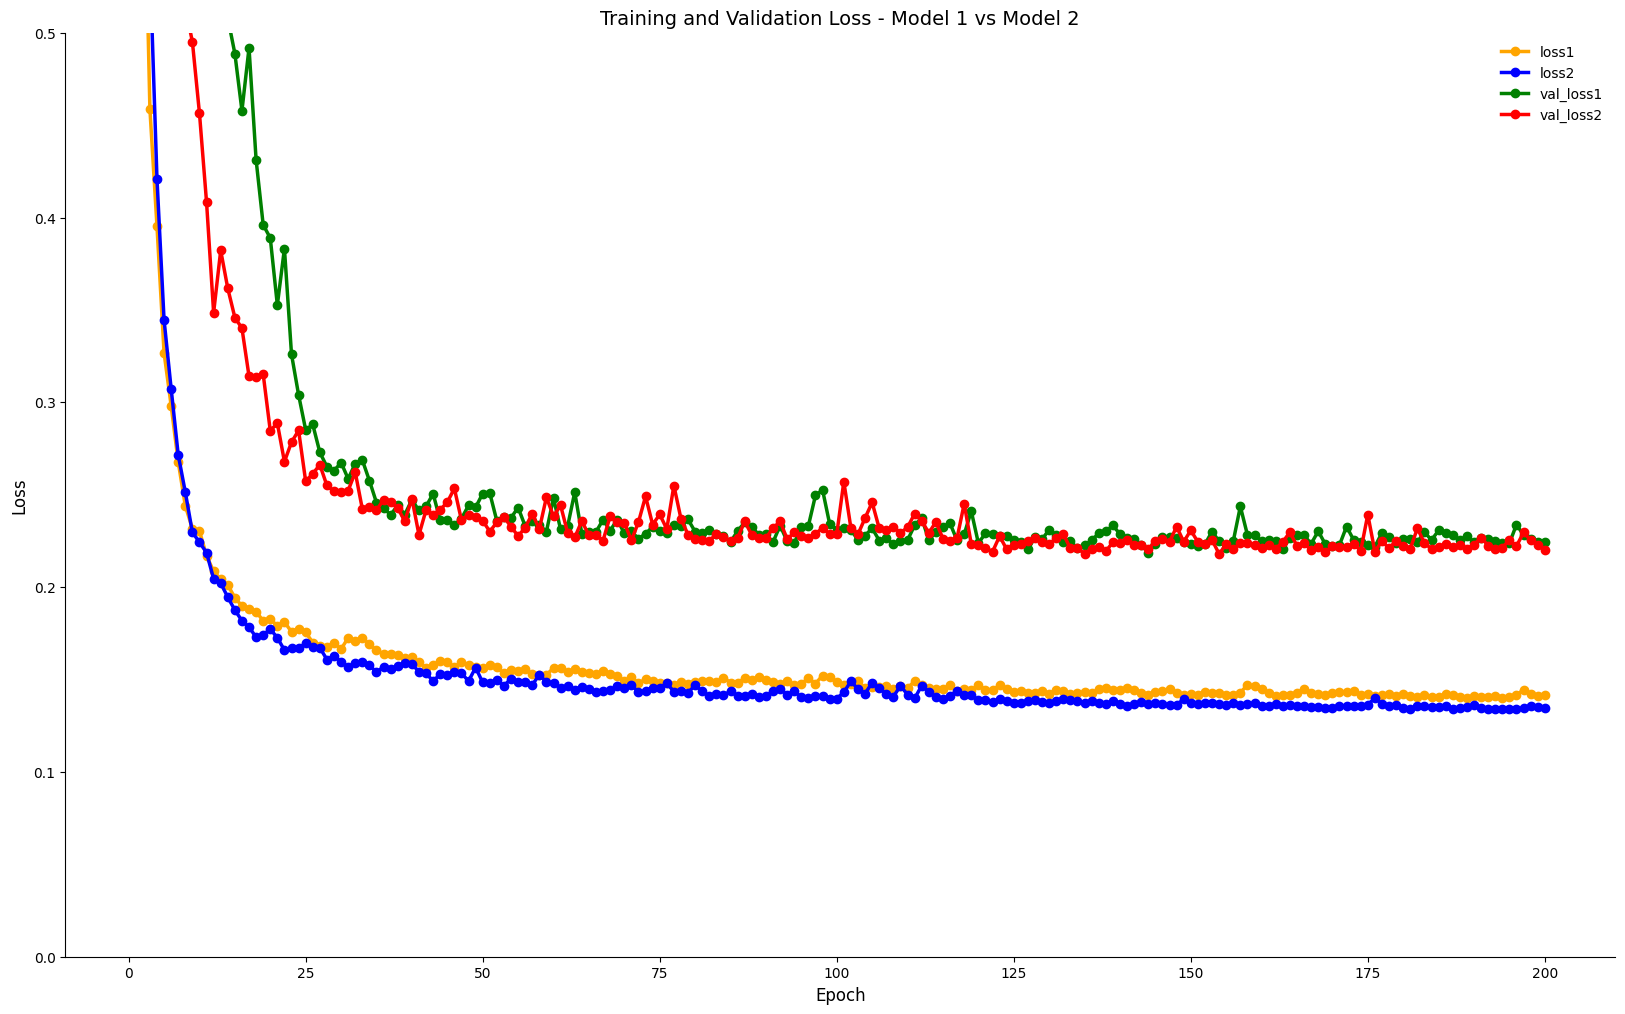

In [48]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, val_loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, val_loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2.5, color="green", label="val_loss1")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2.5, color="red", label="val_loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss - Model 1 vs Model 2', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()

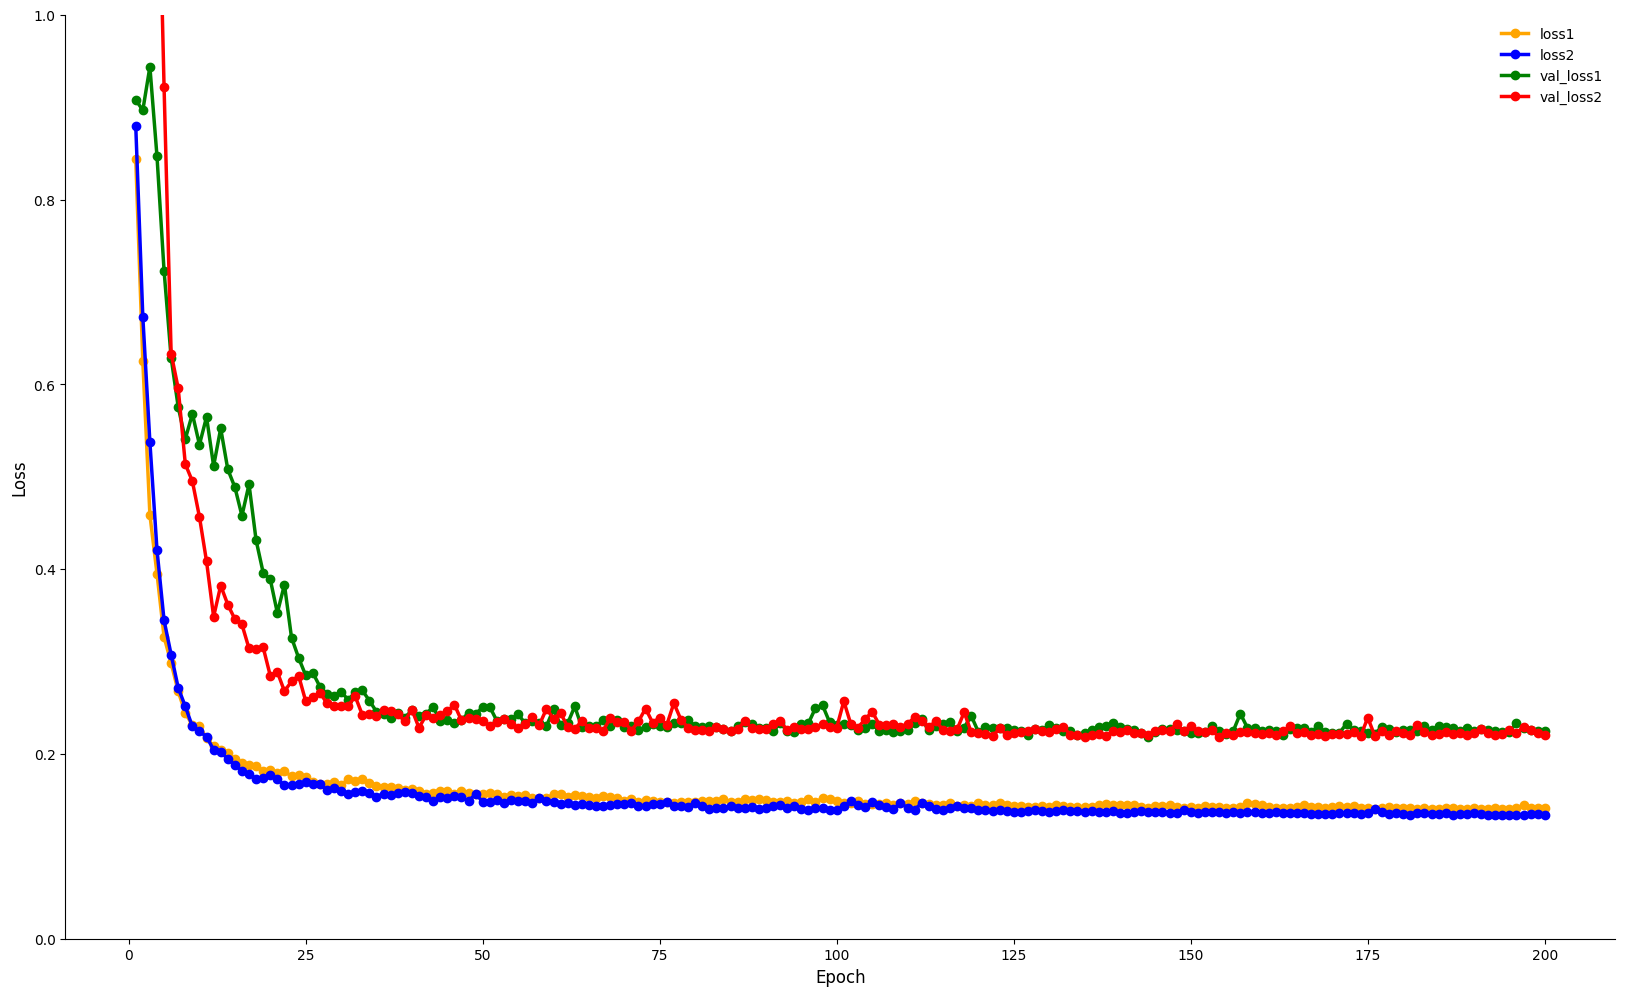

In [49]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, val_loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, val_loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2.5, color="green", label="val_loss1")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2.5, color="red", label="val_loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
'Training and Validation Loss - Model 1 vs Model 2'
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 1))

plt.show()

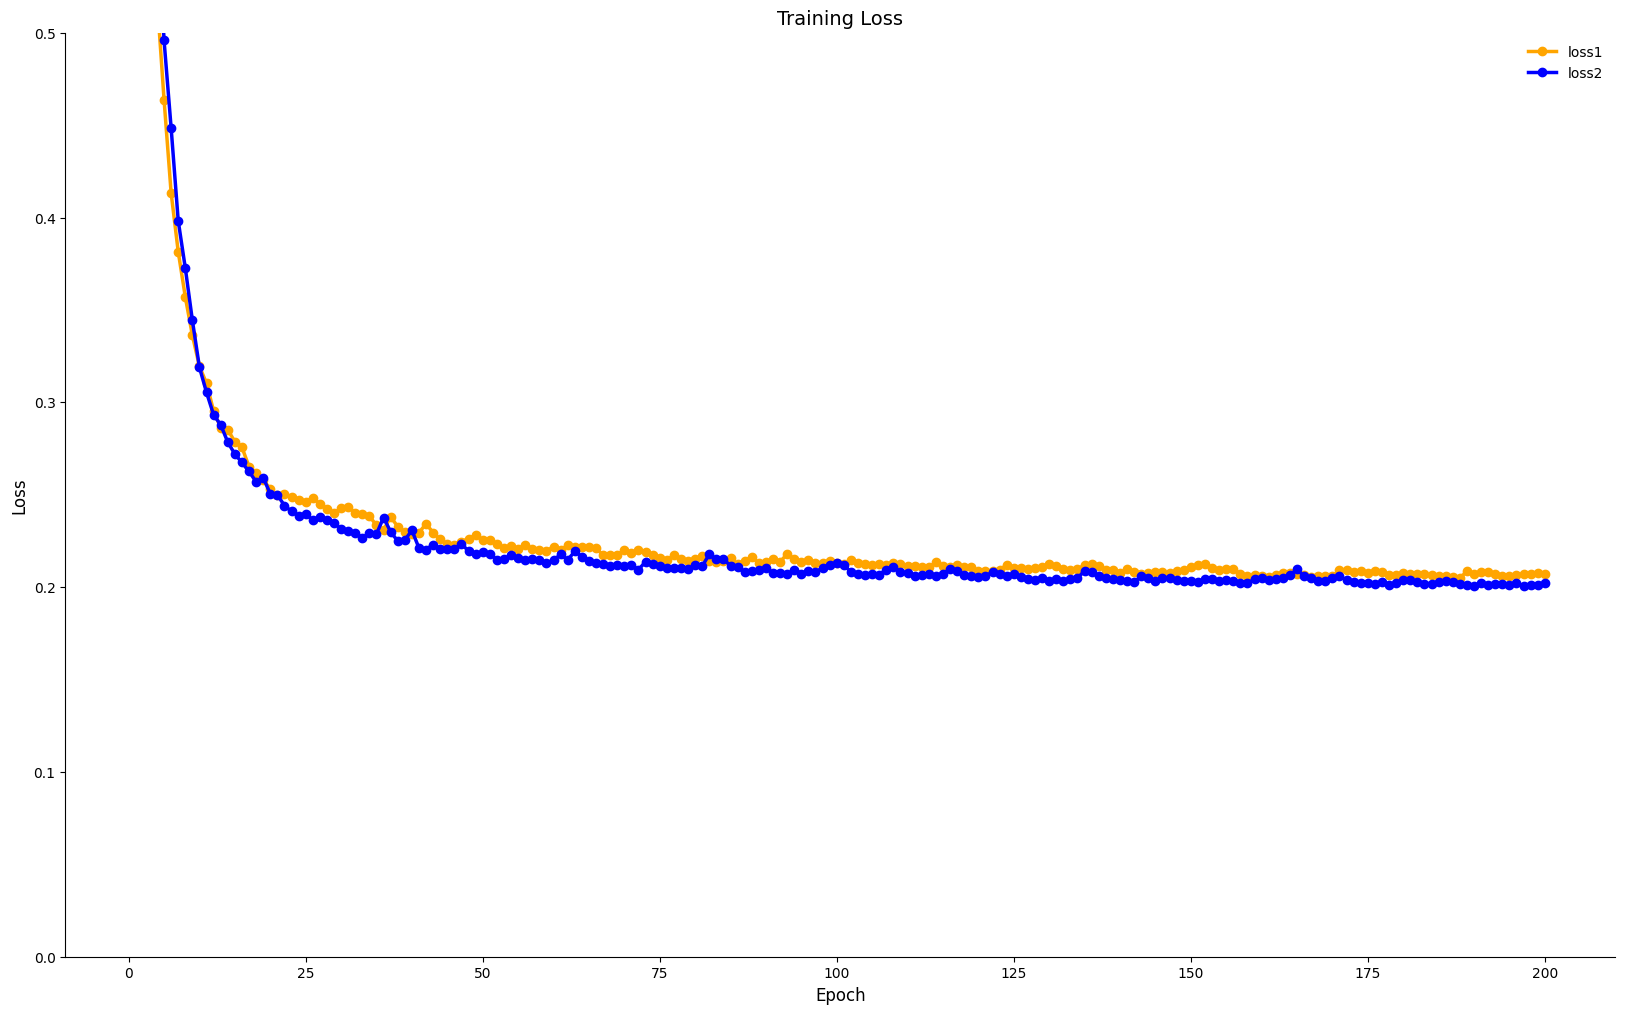

In [ ]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()


##### ***Model prediction 2***

###### ***Model prediction 2 - Adam***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 524ms/step
Shape of testing data: (1, 64, 64, 64, 1)


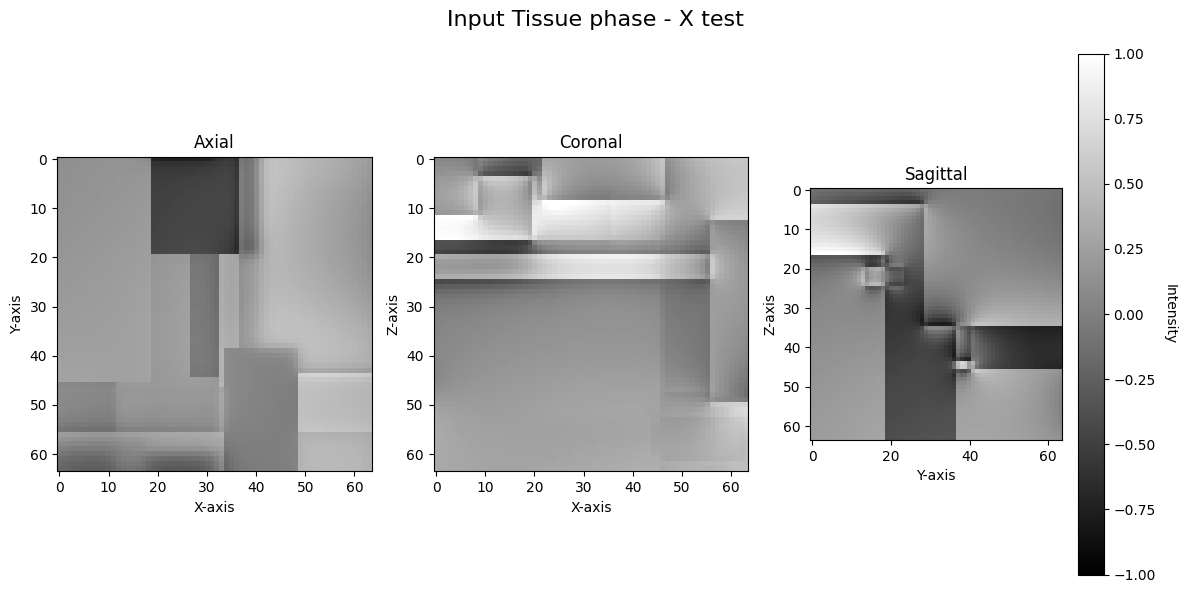

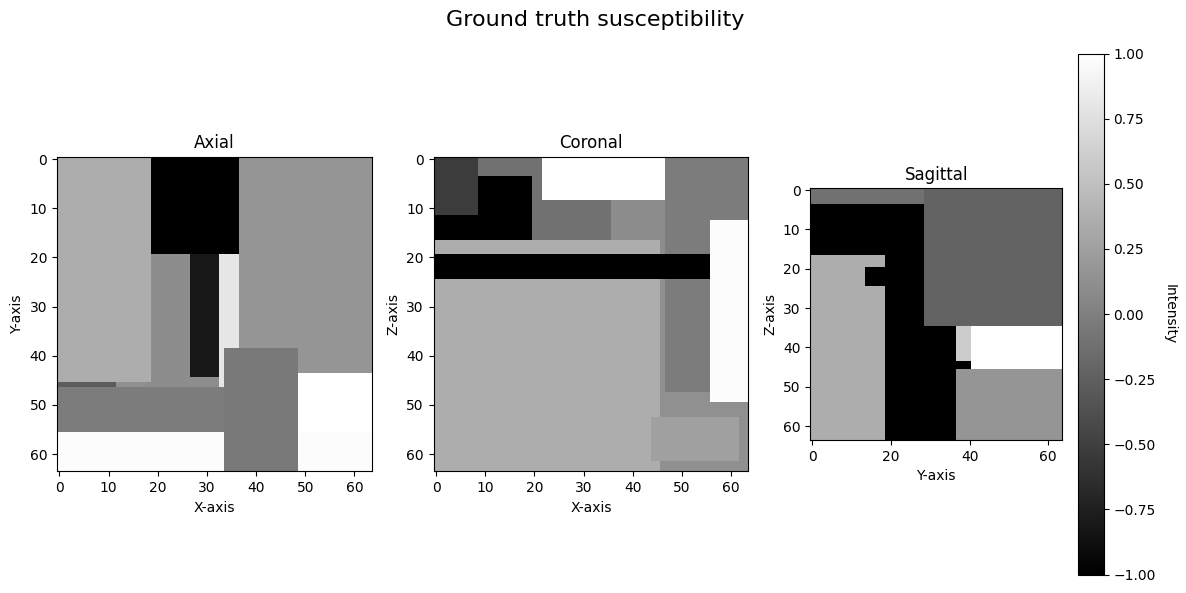

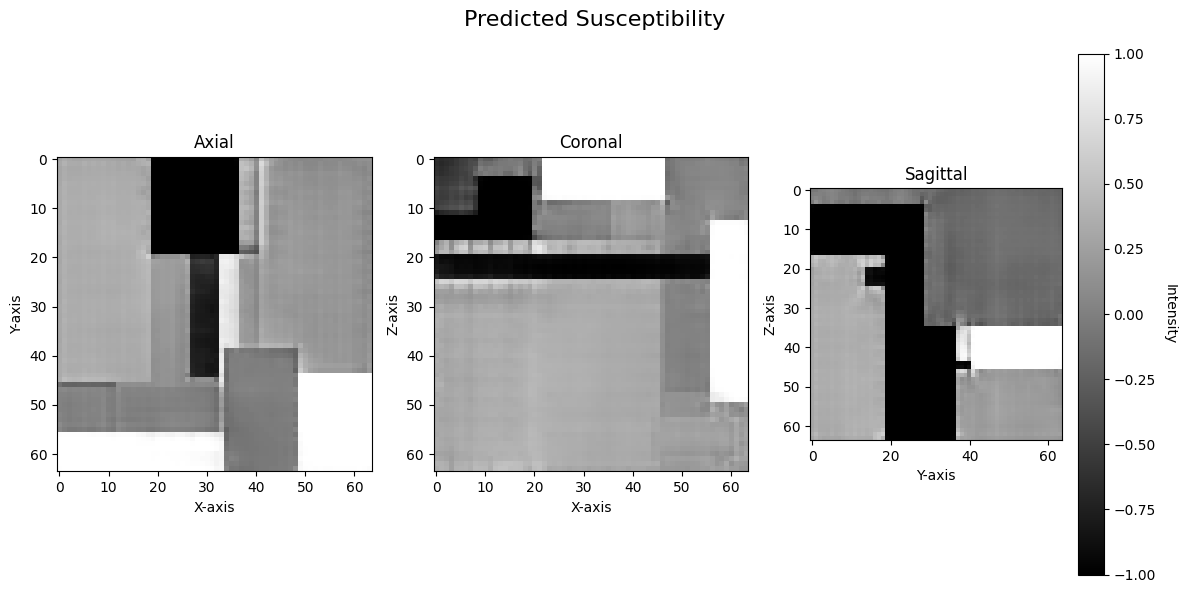

In [ ]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model2.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 41ms/step
(1, 160, 160, 160, 1)


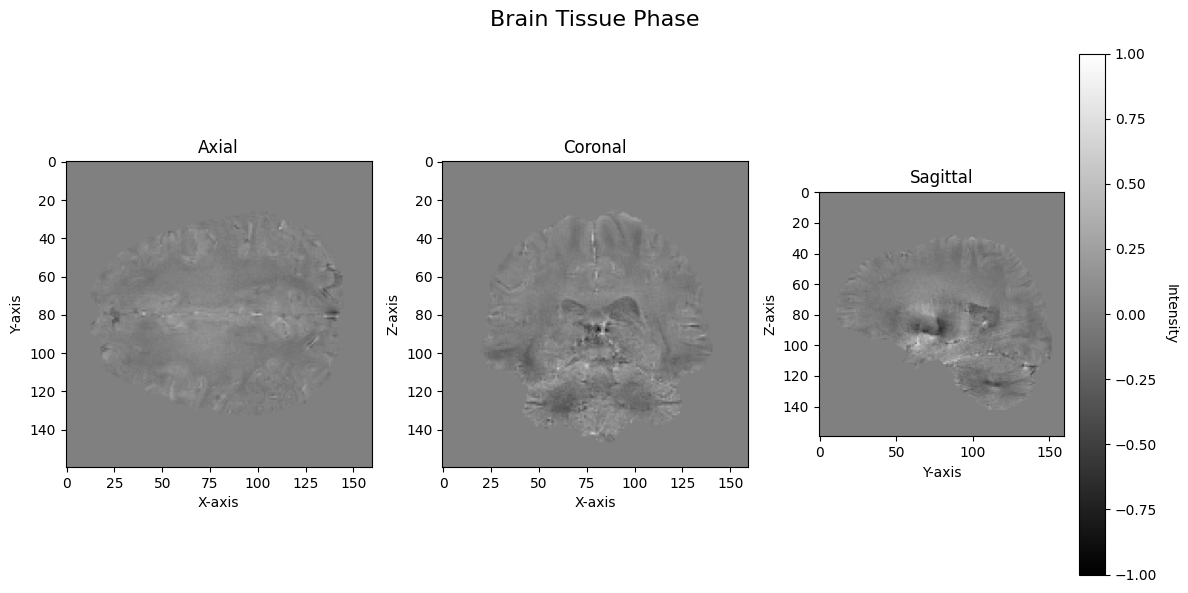

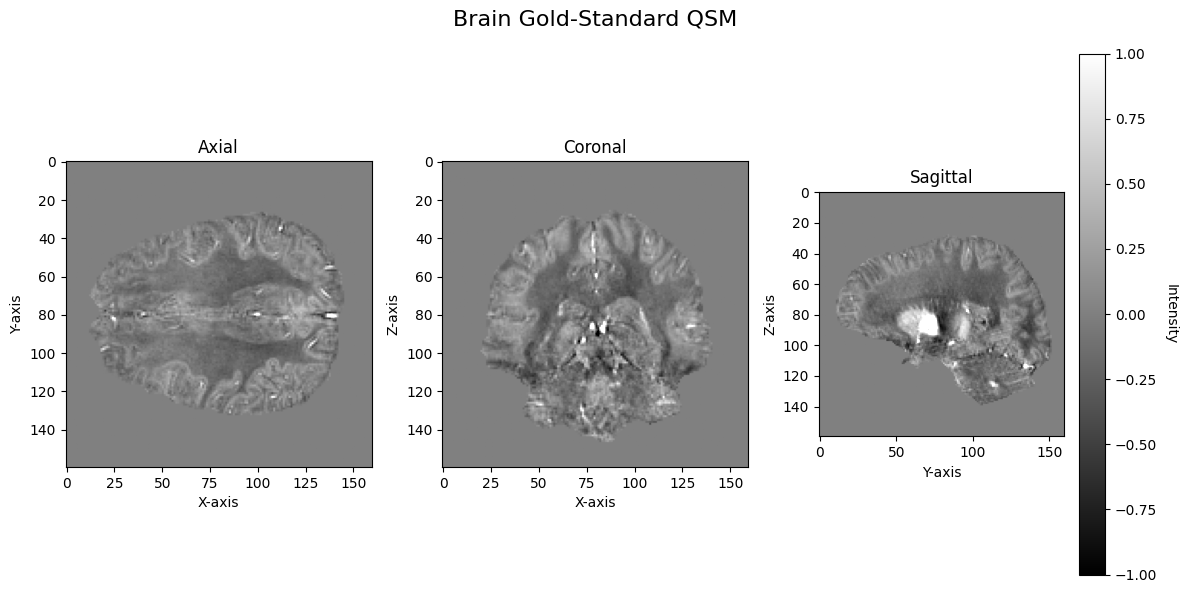

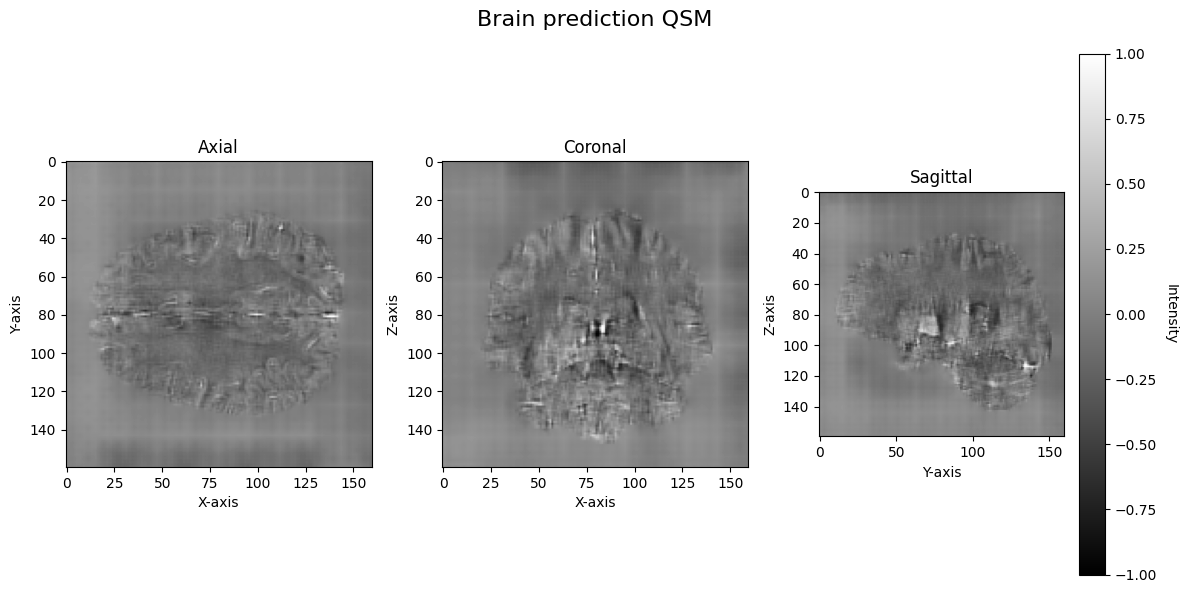

In [ ]:
# Predictions of validations with 35% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain prediction QSM') 

(1, 160, 160, 160, 1)
1/1 [==============================] - 2s 2s/step
(1, 160, 160, 160, 1)


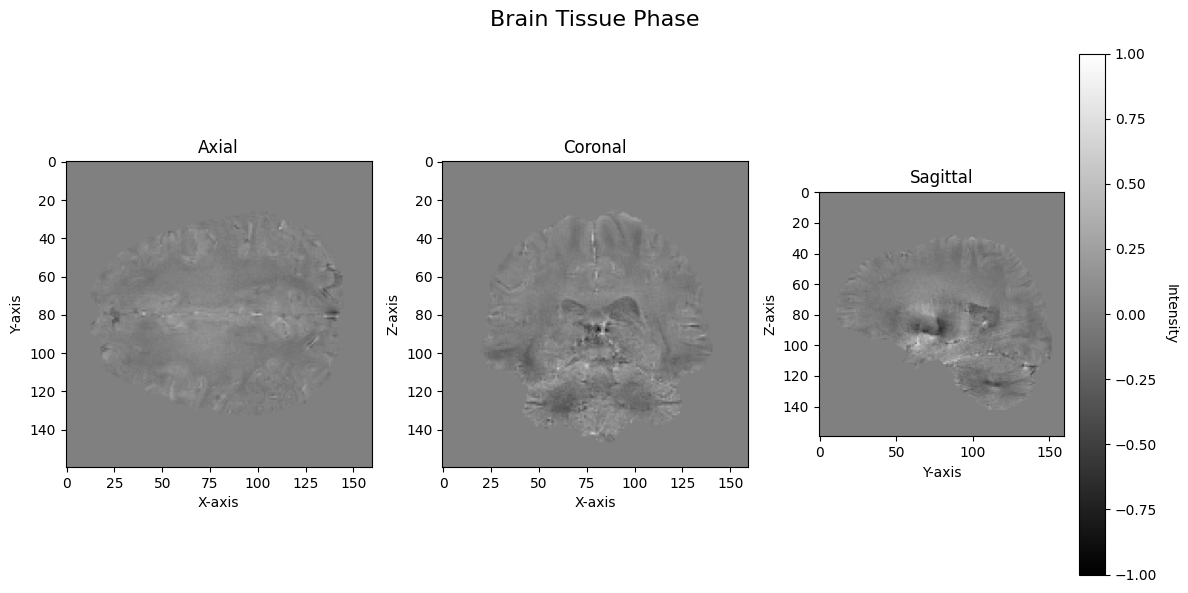

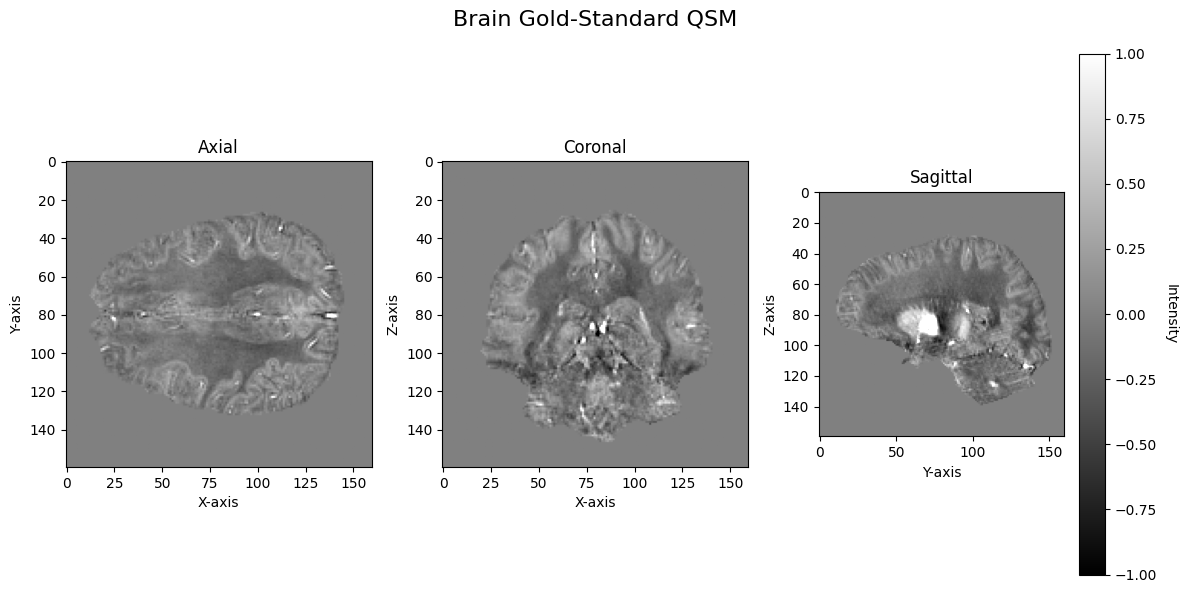

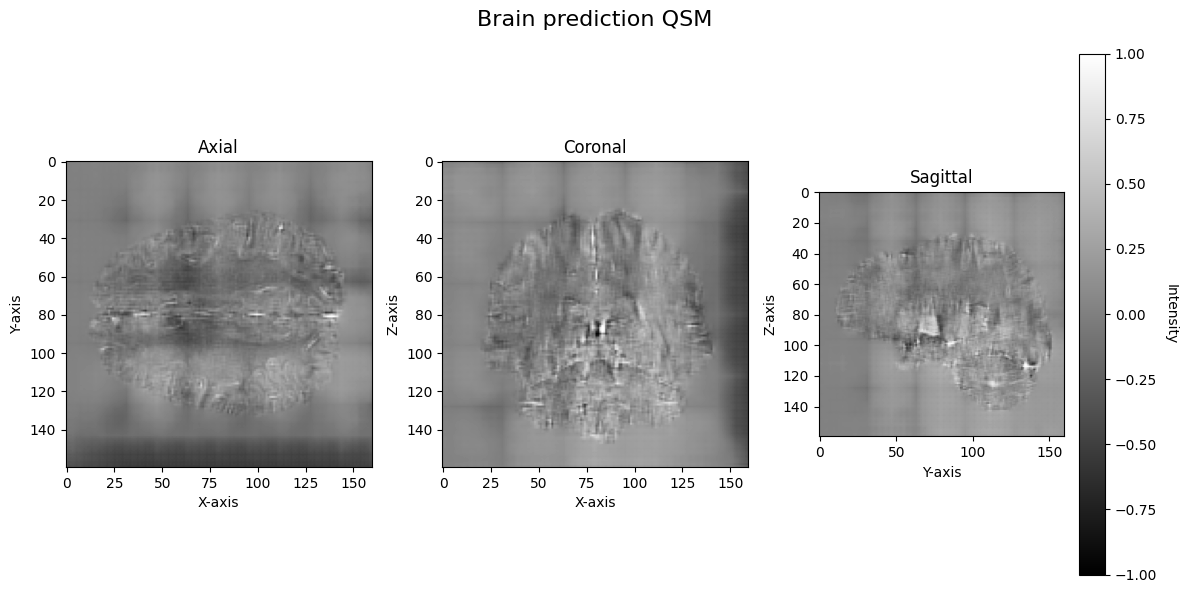

In [ ]:
# Predictions of validations with 20% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain prediction QSM') 

###### ***Model prediction 2 - Nadam optimizer***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 525ms/step
Shape of testing data: (1, 64, 64, 64, 1)


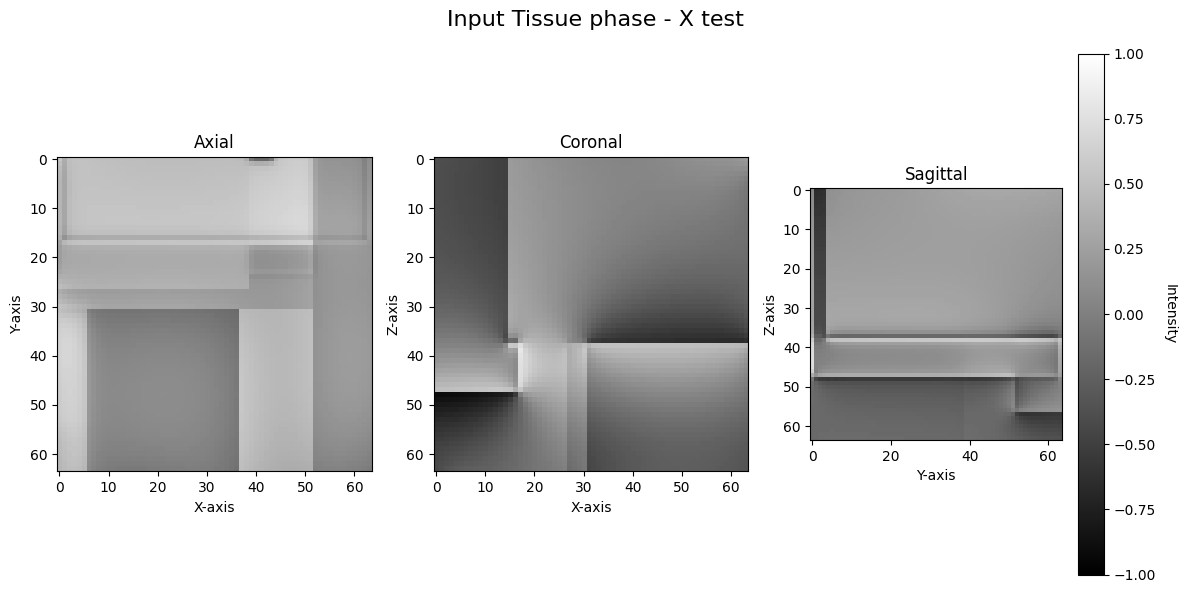

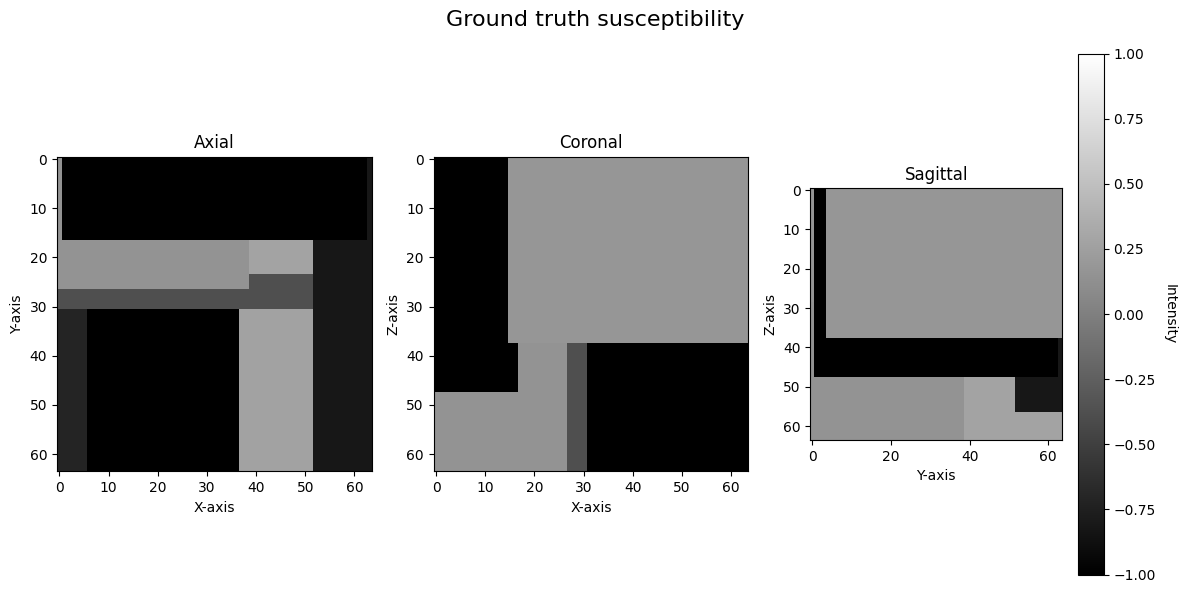

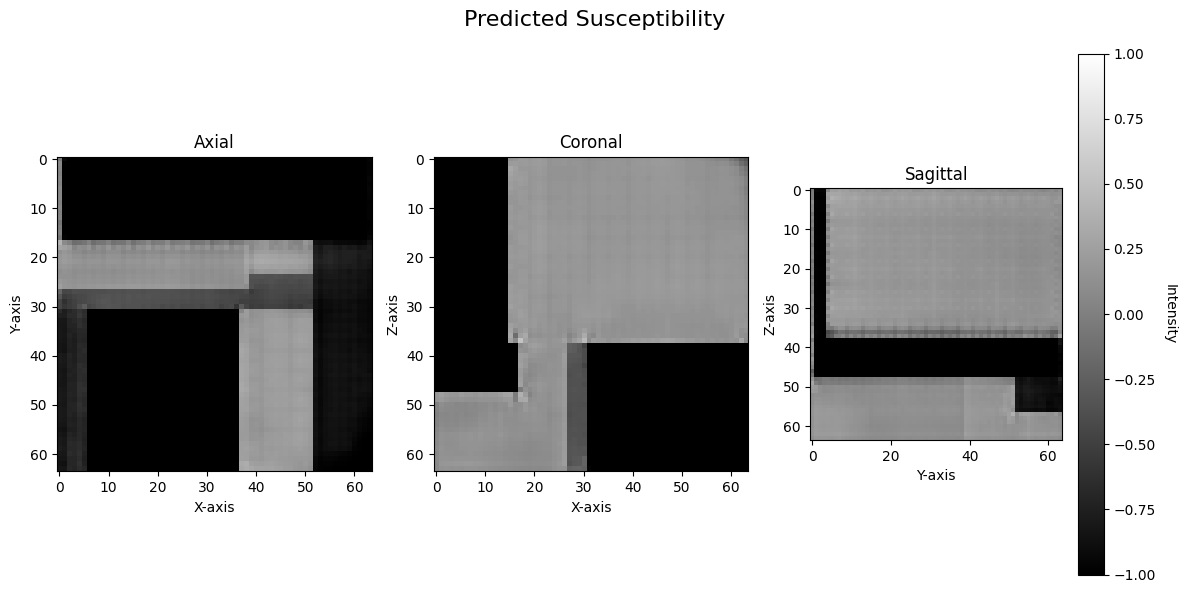

In [50]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model2.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 38ms/step
(1, 160, 160, 160, 1)


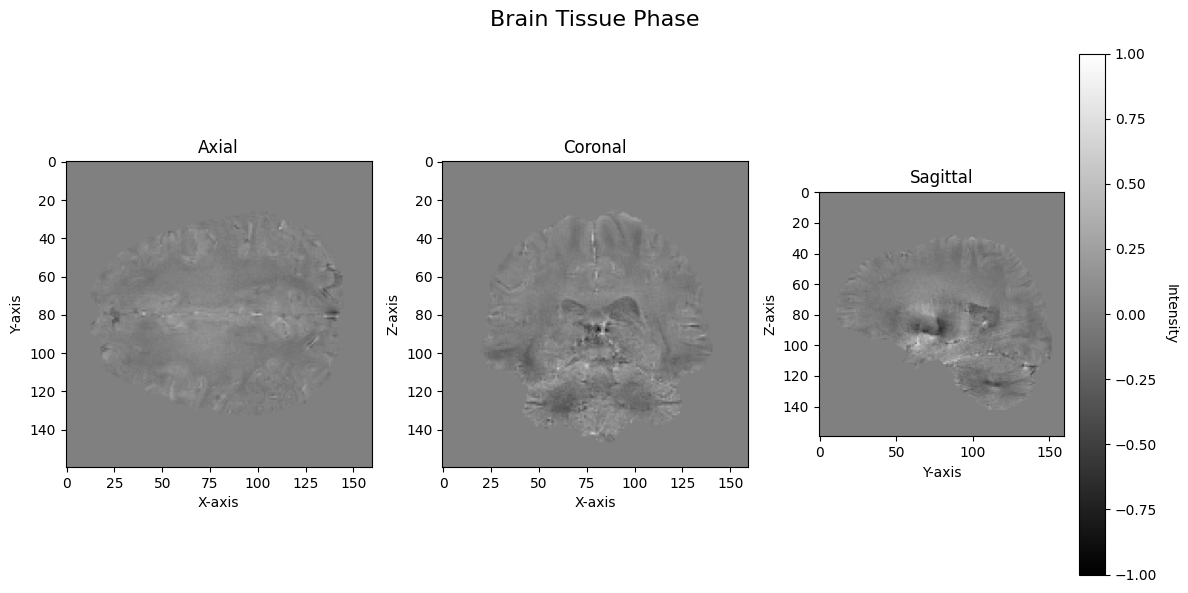

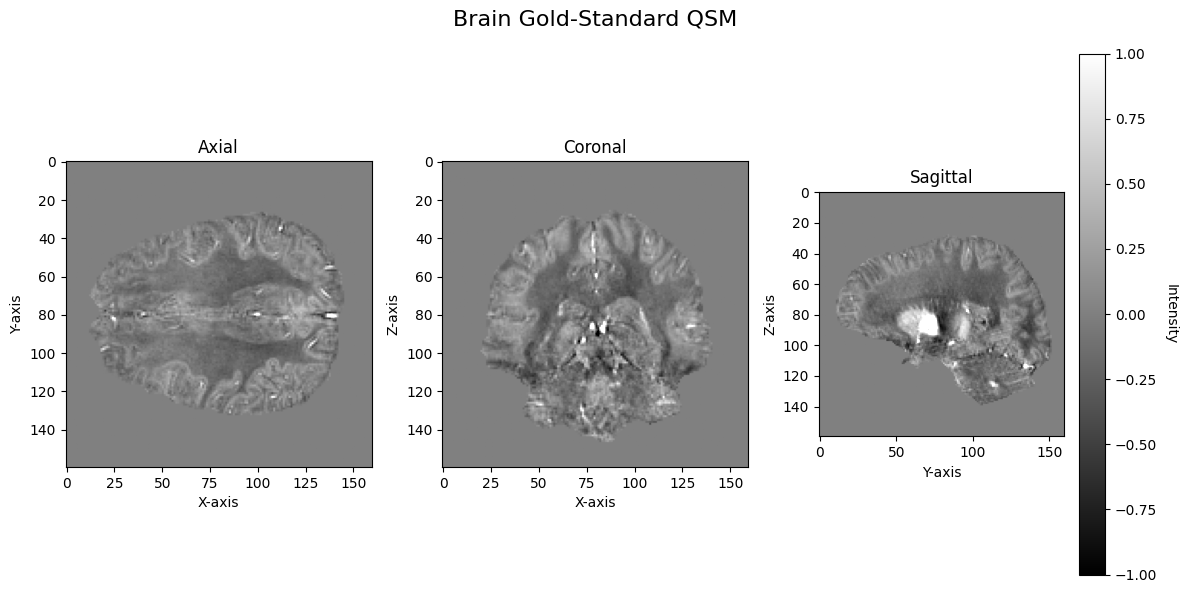

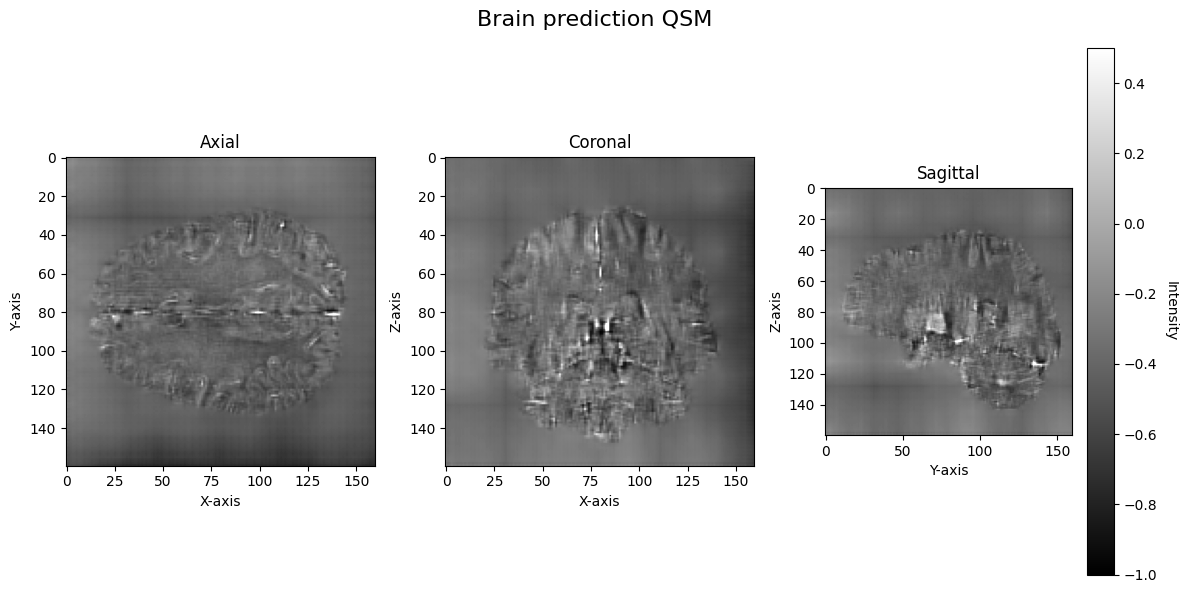

In [58]:
# Predictions of validations with 20% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=0.5, title='Brain prediction QSM') 

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
